## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import re
import string
import ast
import mmh3
import matplotlib.pyplot as plt
import openai
import sys
import yaml
import threading
import networkx as nx
import warnings
import nltk

from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from tqdm import tqdm
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import davies_bouldin_score
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from networkx.algorithms import community
from sklearn.metrics import davies_bouldin_score, rand_score, normalized_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
from openai import OpenAI
from nltk.corpus import wordnet

## Utils

In [2]:
def load_data(kind="processed"):
  """
  Load the data from the data folder.
  args:
    kind: "raw" or "processed"
  """
  if kind == "raw":
    df = pd.read_csv('../data/raw/jobs.csv', sep=';')
  elif kind == "processed":
    df = pd.read_csv('../data/processed/cleaned_jobs.csv', sep=';')
  elif kind == "ground_truth":
    df = pd.read_csv('../clusters/ground_truth_gpt.csv')
  elif kind == "skills":
    df = pd.read_csv('../extracted_skills/skills_extracted_gpt3_v2.csv')
  return df


def is_english(text):
  try:
    return detect(text) == 'en'
  except:
    return False


def apply_kmeans(tfidf_matrix, k=5):
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
  return kmeans.fit_predict(tfidf_matrix.toarray())


def words2sentence(word_list):
  return " ".join(word_list)


def apply_tftidf(data):
  vectorizer = TfidfVectorizer()
  return vectorizer.fit_transform(data)


def visualize_cluster(data,
                      cluster,
                      reduce_dim=True,
                      savefig=False,
                      filename="cluster.png",
                      name="Cluster method"):
  """
  Visualize the clusters
  Data: 2d numpy array of the individual data points that were used for clustering
  cluster: 1d numpy array of the cluster labels
  reduced_dim: Boolean, if True, perform pca to 2 dimensions
  """

  if reduce_dim:
    pca = PCA(n_components=2)
    data = pca.fit_transform(data)

  plt.figure(figsize=(10, 6))
  plt.scatter(data[:, 0], data[:, 1], c=cluster,
              cmap='tab20', edgecolor='black', alpha=0.7, s=100)
  plt.title(name, fontsize=16, fontweight='bold')
  plt.xlabel("PCA 1", fontsize=14)
  plt.ylabel("PCA 2", fontsize=14)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  if savefig:
    plt.savefig(f"../figures/{filename}")
  plt.show()


def visualize_ground_truth(gt, savefig=False, filename="ground_truth.png"):
  plt.figure(figsize=(10, 6))
  plt.bar(gt["category"].value_counts().index,
          gt["category"].value_counts().values, color='dodgerblue')

  plt.xticks(rotation=75)
  plt.title("Ground truth distribution", fontsize=16, fontweight='bold')
  plt.xlabel("Category", fontsize=14)
  plt.ylabel("Count", fontsize=14)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  if savefig:
    plt.savefig(f"../figures/{filename}")
  plt.show()


def skill_cleanup(data):

  # skills is a list of strings, connect them into one string

  data["skills_string"] = data["skills"].apply(lambda x: ' '.join(x))

  print(data.head())
  return data


## Logger

In [3]:
def working_on(message):
  print(":wrench: [bold green]WORKING ON[/bold green]: " + message)


def warning(message):
  print(":tomato: [bold red]WARNING[/bold red]: " + message)


def info(message):
  print(":information_source: [bold yellow]INFO[/bold yellow]: " + message)


def success(message):
  print(":white_check_mark: [bold green]SUCCESS[/bold green]: " + message)


def winner(message):
    print(":trophy: [bold yellow]WINNER[/bold yellow]: " + message)

## SCRAPING

In [4]:
class LinkedinScraper:
    def __init__(self, location, keywords=None, amount=50):
        self.location = location
        self.keywords = keywords
        self.amount = amount
        self.job_ids = []
        self.jobs = []

        if amount > 1000:
            print(
                "⚠️ WARNING: LinkedIn only allows you to scrape 1000 jobs per search. ⚠️"
            )
            print("⚠️ WARNING: The amount will be set to 1000. ⚠️")
            self.amount = 1000
        if keywords == None:
            self.all_jobs_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?location={self.location}"
            self.all_jobs_url += "&start={}"
        else:
            self.all_jobs_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={self.keywords}&location={self.location}"
            self.all_jobs_url += "&start={}"

        self.job_url = "https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{}"

    def save_to_csv(self, filename="../data/raw/jobs.csv"):
        print("📝 Saving jobs to CSV file...")
        if os.path.isfile(filename):
            existing_ids = set(pd.read_csv(filename, sep=";")["id"])
        else:
            existing_ids = set()

        # Filter out jobs that are already saved in the CSV

        unique_jobs = [job for job in self.jobs if int(job["id"]) not in existing_ids]

        if unique_jobs:
            df = pd.DataFrame(unique_jobs)
            df.to_csv(
                filename,
                mode="a",
                sep=";",
                header=not os.path.isfile(filename),
                index=False,
            )

    def _get_job_ids(self):
        for i in tqdm(
            range(0, self.amount, 25),
            desc="💼 Scraping job IDs 🔍",
            ascii=True,
            colour="#0077B5",
        ):
            res = requests.get(self.all_jobs_url.format(i))
            soup = BeautifulSoup(res.text, "html.parser")
            alljobs_on_this_page = soup.find_all("li")
            for x in range(0, len(alljobs_on_this_page)):
                try:
                    jobid = (
                        alljobs_on_this_page[x]
                        .find("div", {"class": "base-card"})
                        .get("data-entity-urn")
                        .split(":")[3]
                    )
                    self.job_ids.append(jobid)
                except:
                    print("❌ One Job ID could not be retrieved ❌")
                    pass

    def scrape(self):
        # First scrape the job ids
        self._get_job_ids()

        # Then scrape the job details
        for j in tqdm(
            range(0, len(self.job_ids)),
            desc="💼 Scraping job details 🔍",
            ascii=True,
            colour="#0077B5",
        ):
            job = {}  # Create a new job dictionary
            resp = requests.get(self.job_url.format(self.job_ids[j]))
            soup = BeautifulSoup(resp.text, "html.parser")

            job["id"] = self.job_ids[j]
            job["date_scraped"] = pd.Timestamp.now()
            job["keyword_scraped"] = self.keywords
            job["location_scraped"] = self.location
            job["linkedin_num"] = j

            try:
                job["company"] = (
                    soup.find("div", {"class": "top-card-layout__card"})
                    .find("a")
                    .find("img")
                    .get("alt")
                )
            except:
                job["company"] = None

            try:
                job["title"] = (
                    soup.find("div", {"class": "top-card-layout__entity-info"})
                    .find("a")
                    .text.strip()
                )
            except:
                job["title"] = None

            try:
                job["num_applicants"] = (
                    soup.find("div", {"class": "top-card-layout__entity-info"})
                    .find("h4")
                    .find("span", {"class": "num-applicants__caption"})
                    .text.strip()
                )
            except:
                job["num_applicants"] = None

            try:
                job["date_posted"] = (
                    soup.find("div", {"class": "top-card-layout__entity-info"})
                    .find("h4")
                    .find("span", {"class": "posted-time-ago__text"})
                    .text.strip()
                )
            except:
                job["date_posted"] = None

            try:
                ul_element = soup.find(
                    "ul", {"class": "description__job-criteria-list"}
                )

                for li_element in ul_element.find_all("li"):
                    subheader = li_element.find(
                        "h3", {"class": "description__job-criteria-subheader"}
                    ).text.strip()
                    criteria = li_element.find(
                        "span",
                        {
                            "class": "description__job-criteria-text description__job-criteria-text--criteria"
                        },
                    ).text.strip()

                    if "Seniority level" in subheader:
                        job["level"] = criteria
                    elif "Employment type" in subheader:
                        job["employment_type"] = criteria
                    elif "Job function" in subheader:
                        job["function"] = criteria
                    elif "Industries" in subheader:
                        job["industries"] = criteria
            except:
                job["level"] = None
                job["employment_type"] = None
                job["function"] = None
                job["industries"] = None

            try:
                job["description"] = soup.find(
                    "div", {"class": "description__text description__text--rich"}
                ).text.strip()
            except:
                job["description"] = None

            self.jobs.append(job)

            # Checkpoint to save the jobs to the CSV file every 500 jobs
            if (j + 1) % 500 == 0:
                self.save_to_csv()
                self.jobs = []

        if self.jobs:
            self.save_to_csv()


## PREPROCESSING

In [5]:
def remove_words_with_numbers(word_list):
    """
    Takes a string representation of a list of words as input,
    removes any special characters from the words, and then removes any words that contain numbers.

    Args:
      word_list_str: A string representation of a list of words.

    Returns:
      The function `remove_words_with_numbers` returns a list of words without any special characters or
    numbers.
    """
    word_list_without_special = [
        re.sub(r"[^a-zA-Z0-9\s]", "", word) for word in word_list
    ]
    word_list_without_numbers = [
        word for word in word_list_without_special if not re.search(r"\d", word)
    ]
    return word_list_without_numbers


def convert_date_posted(date_str, date_scraped):
    try:
        days_ago = int(date_str.split(" ")[0])
        actual_date = pd.to_datetime(date_scraped) - pd.Timedelta(days=days_ago)
        return actual_date
    except:
        return date_scraped  # If the format is not "x days ago", use the scraped date


def split_combined_words(text):
    """
    Since during the scraping, some words are combined, e.g. "requirementsYou're" or "offerings.If" we need to split them
    Splits words at:
    1. Punctuation marks followed by capital letters.
    2. Lowercase letters followed by uppercase letters.
    """
    # 1. split
    text = re.sub(r"([!?,.;:])([A-Z])", r"\1 \2", text)

    # 2. split
    text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text)

    return text


def text_preprocessing(text):
    """
    Preprocesses text by:
      - Splitting combined words
      - Tokenizing
      - Removing stopwords
      - Remove punctuation
      - Lemmatizing
    """

    text = split_combined_words(text)
    text = text.lower()

    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", "", text)
    # Remove numbers
    text = re.sub(r"\d+", "", text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words("english"))

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    punctuation = {
        "!",
        ",",
        ".",
        ";",
        ":",
        "?",
        "(",
        ")",
        "[",
        "]",
        "-",
        "+",
        '"',
        "*",
        "—",
        "•",
        "’",
        "‘",
        "“",
        "”",
        "``",
    }
    tokens = [w for w in tokens if w not in punctuation]

    # Remove last 3 words since they are always the same (scraped buttons from the website)
    tokens = tokens[:-3]

    return tokens


def preprocess():
    """
    Main function of the preprocessing module.
    Loads the raw data and does the following:
    - Checks for english language
    - Removes rows with missing descriptions
    - Inferes the date posted
    - Preprocesses the description
    - Saves the preprocessed data to data/processed/cleaned_jobs.csv
    """

    working_on("Loading data")
    df = load_data(kind="raw")

    # Remove duplicates
    df.drop_duplicates(subset=["id"], inplace=True)
    df.drop_duplicates(subset=["description"], inplace=True)
    # Filter out jobs with missing descriptions
    df = df[df["description"].notna()]

    working_on("Filtering out non-english descriptions ...")
    for index, row in df.iterrows():
        if not is_english(row["description"][:100]):
            df.drop(index, inplace=True)

    working_on("Infering dates ...")
    df["date_posted"] = df.apply(
        lambda x: convert_date_posted(x["date_posted"], x["date_scraped"]), axis=1
    )

    # Lower case all text
    df["title"] = df["title"].str.lower()
    df["function"] = df["function"].str.lower()
    df["industries"] = df["industries"].str.lower()
    df["industries"] = df["industries"].str.replace("\n", " ")

    # Removing outliers (where industries is whole description of offer)
    df["industries_length"] = df["industries"].str.split()
    df["industries_length"] = df["industries_length"].str.len()
    df = df[df["industries_length"] < 15]
    df.drop(columns=["industries_length"], inplace=True)

    df["industries"] = df["industries"].str.replace(" and ", ",")
    df["function"] = df["function"].str.replace(" and ", ",")
    df["industries"] = df["industries"].str.replace("/", ",")
    df["function"] = df["function"].str.replace("/", ",")

    df["industries"] = df["industries"].str.replace(r",,|, ,", ",")
    df["function"] = df["function"].str.replace(r",,|, ,", ",")

    tqdm.pandas(desc="🐼 Preprocessing description", ascii=True, colour="#0077B5")

    df["description"] = df["description"].progress_apply(text_preprocessing)

    # Remove rows with empty descriptions or descriptions containing less than 3 words
    df = df[df["description"].map(len) > 3]

    # Remove special characters and numbers from the tokenized list
    df["description"] = df["description"].apply(lambda x: remove_words_with_numbers(x))

    df = df.reset_index(drop=True)

    working_on("Saving preprocessed data ...")
    df.to_csv("../data/processed/cleaned_jobs.csv", index=False, sep=";")

## TF IDF CLUSTERING

In [6]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def TFIDF_cluster(data, save_clusters=True, n_clusters=20):
    """
    data: pandas dataframe (cleaned jobs)
    save_clusters: Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    n_clusters: Number of clusters
    """

    data["description"] = data["description"].apply(words2sentence)
    tfidf_matrix = apply_tftidf(data["description"])

    data["cluster"] = apply_kmeans(tfidf_matrix, k=n_clusters)

    if save_clusters:
        data[["id", "cluster"]].to_csv("../clusters/tfidf_clusters.csv", index=False)

    dbs = round(davies_bouldin_score(tfidf_matrix.toarray(), data["cluster"]), 3)

    success("David Bouldin score: " + str(dbs))

    return data[["id", "cluster"]], tfidf_matrix.toarray()


def TFIDF_industries_and_functions_cluster(data, save_clusters=False, n_clusters=20):
    """
    data: pandas dataframe (cleaned jobs)
    save_clusters: Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    n_clusters: Number of clusters
    """

    data["industries"] = data["function"] + ", " + data["industries"]
    data["industries"] = data["industries"].str.replace(",,", ",", regex=False)

    tfidf_matrix = apply_tftidf(data["industries"])

    data["cluster"] = apply_kmeans(tfidf_matrix, k=n_clusters)

    if save_clusters:
        data[["id", "cluster"]].to_csv(
            "../clusters/tfidf_industries_and_functions_clusters.csv", index=False
        )

    dbs = round(davies_bouldin_score(tfidf_matrix.toarray(), data["cluster"]), 3)

    success("David Bouldin score: " + str(dbs))

    return data[["id", "cluster"]], tfidf_matrix.toarray()


# Define the pos_tagger function
def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None


def get_tfidf_vectors(description_type):
    """
    Get TF-IDF vectors and keywords for each description.

    Parameters:
    - description_type: List of text descriptions.

    Returns:
    - vectors: TF-IDF vectors.
    - all_keywords: List of keywords for each description.
    """
    # create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # fit and transform the text descriptions using the TF-IDF vectorizer
    vectors = vectorizer.fit_transform(description_type)

    # get the feature names (words) corresponding to the TF-IDF vectors
    feature_names = vectorizer.get_feature_names_out()

    # convert the sparse TF-IDF matrix to a dense representation
    dense = vectors.todense()
    denselist = dense.tolist()

    # initialize a list to store keywords for each description
    all_keywords = []

    # iterate through each description in the dense representation
    for description in denselist:
        # extract keywords (feature names) where the TF-IDF value is greater than 0
        keywords = [feature_names[i] for i, word in enumerate(description) if word > 0]

        # append the keywords for the current description to the list
        all_keywords.append(keywords)

    return vectors, all_keywords, vectorizer


def TFIDF_verbs_cluster(data, save_clusters=True, n_clusters=20):
    """
    data: pandas dataframe (cleaned jobs)
    save_clusters: Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    n_clusters: Number of clusters
    """

    data = data[["id", "description"]]

    data = data.copy()
    working_on("Extracting verbs from descriptions ...")
    data.loc[:, "description_verb"] = data["description"].apply(
        lambda x: [
            word
            for word, pos_tag in [
                (word, pos_tagger(tag[1][0].upper()))
                for word, tag in zip(eval(x), nltk.pos_tag(eval(x)))
                if pos_tagger(tag[1][0].upper()) == wordnet.VERB
            ]
            if pos_tag is not None
        ]
    )

    # data['description_verb'] = data['description'].apply(lambda x: [word for word, pos_tag in [(word, pos_tagger(tag[1][0].upper(
    # ))) for word, tag in zip(eval(x), nltk.pos_tag(eval(x))) if pos_tagger(tag[1][0].upper()) == wordnet.VERB] if pos_tag is not None])

    description_verb = data["description_verb"]

    description_verb_strings = [
        " ".join(description) for description in description_verb
    ]

    working_on("Clustering verbs ...")
    model = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10)

    vectors, all_keywords, vectorizer = get_tfidf_vectors(description_verb_strings)

    # Fit the model to the TF-IDF vectors
    model.fit(vectors)

    # Get the indices that sort the cluster centers in descending order
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]

    # Get the feature names (words) from the TF-IDF vectorizer
    terms = vectorizer.get_feature_names_out()

    # Write the top terms for each cluster to a text file
    #with open("results/kmeans_verb_results.txt", "w", encoding="utf-8") as f:
    #    for i in range(n_clusters):
    #        f.write(f"Cluster {i+1}")
    #        f.write("\n")
    #        for ind in order_centroids[i, :10]:
    #            f.write(
    #                " %s" % terms[ind],
    #            )
    #            f.write("\n")
    #        f.write("\n")
    #        f.write("\n")

    # Predict cluster assignments for each document in the TF-IDF vectors
    kmean_indicates = model.fit_predict(vectors)

    # Add a 'cluster' column to the 'data' DataFrame
    # data['cluster_verb'] = kmean_indicates
    data.loc[:, "cluster_verb"] = kmean_indicates

    data = data.rename(columns={"cluster_verb": "cluster"})

    # Save the results to a CSV file with 'id' and 'cluster' columns
    if save_clusters:
        result_df = data[["id", "cluster"]]
        result_df.to_csv("../clusters/tfidf_verb__clusters.csv", index=False)

    dbs = round(davies_bouldin_score(vectors.toarray(), kmean_indicates), 3)

    success("David Bouldin score: " + str(dbs))

    return data[["id", "cluster"]], vectors.toarray()


def TFIDF_nouns_cluster(data, save_clusters=True, n_clusters=20):
    """
    data: pandas dataframe (cleaned jobs)
    save_clusters: Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    n_clusters: Number of clusters
    """

    data = data[["id", "description"]]

    data = data.copy()
    working_on("Extracting nouns from descriptions ...")
    data.loc[:, "description_noun"] = data["description"].apply(
        # use a lambda function to extract nouns using POS tagging
        lambda x: [
            word  # extract the word
            for word, pos_tag in [
                (word, pos_tagger(tag[1][0].upper()))  # POS tag each word
                # pair each word with its POS tag
                for word, tag in zip(eval(x), nltk.pos_tag(eval(x)))
                # filter for nouns
                if pos_tagger(tag[1][0].upper()) == wordnet.NOUN
            ]
            if pos_tag is not None  # exclude words with undefined POS tags
        ]
    )
    description_noun = data["description_noun"]

    description_noun_strings = [
        " ".join(description) for description in description_noun
    ]

    working_on("Clustering nouns ...")
    model = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10)

    vectors, all_keywords, vectorizer = get_tfidf_vectors(description_noun_strings)

    # Fit the model to the TF-IDF vectors
    model.fit(vectors)

    # Get the indices that sort the cluster centers in descending order
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]

    # Get the feature names (words) from the TF-IDF vectorizer
    terms = vectorizer.get_feature_names_out()

    # Write the top terms for each cluster to a text file
    #with open("results/kmeans_noun_results.txt", "w", encoding="utf-8") as f:
    #    for i in range(n_clusters):
    #        f.write(f"Cluster {i+1}")
    #        f.write("\n")
    #        for ind in order_centroids[i, :10]:
    #            f.write(
    #                " %s" % terms[ind],
    #            )
    #            f.write("\n")
    #        f.write("\n")
    #        f.write("\n")

    # Predict cluster assignments for each document in the TF-IDF vectors
    kmean_indicates = model.fit_predict(vectors)

    # Add a 'cluster' column to the 'data' DataFrame
    # data['cluster_noun'] = kmean_indicates
    data.loc[:, "cluster_noun"] = kmean_indicates

    data = data.rename(columns={"cluster_noun": "cluster"})

    # Save the results to a

    if save_clusters:
        result_df = data[["id", "cluster"]]
        result_df.to_csv("../clusters/tfidf_noun_clusters.csv", index=False)

    dbs = round(davies_bouldin_score(vectors.toarray(), kmean_indicates), 3)

    success("David Bouldin score: " + str(dbs))

    return data[["id", "cluster"]], vectors.toarray()


def TFIDF_adjectives_cluster(data, save_clusters=True, n_clusters=20):
    """
    data: pandas dataframe (cleaned jobs)
    save_clusters: Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    n_clusters: Number of clusters
    """

    data = data[["id", "description"]]

    data = data.copy()
    working_on("Extracting adjectives from descriptions ...")
    data.loc[:, "description_adj"] = data["description"].apply(
        lambda x: [
            word
            for word, pos_tag in [
                (word, pos_tagger(tag[1][0].upper()))
                for word, tag in zip(eval(x), nltk.pos_tag(eval(x)))
                if pos_tagger(tag[1][0].upper()) == wordnet.ADJ
            ]
            if pos_tag is not None
        ]
    )
    description_adj = data["description_adj"]

    description_adj_strings = [" ".join(description) for description in description_adj]

    working_on("Clustering adjectives ...")
    model = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10)

    vectors, all_keywords, vectorizer = get_tfidf_vectors(description_adj_strings)

    # Fit the model to the TF-IDF vectors
    model.fit(vectors)

    # Get the indices that sort the cluster centers in descending order
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]

    # Get the feature names (words) from the TF-IDF vectorizer
    terms = vectorizer.get_feature_names_out()

    # Write the top terms for each cluster to a text file
    #with open("results/kmeans_adj_results.txt", "w", encoding="utf-8") as f:
    #    for i in range(n_clusters):
    #        f.write(f"Cluster {i+1}")
    #        f.write("\n")
    #        for ind in order_centroids[i, :10]:
    #            f.write(
    #                " %s" % terms[ind],
    #            )
    #            f.write("\n")
    #        f.write("\n")
    #        f.write("\n")

    # Predict cluster assignments for each document in the TF-IDF vectors
    kmean_indicates = model.fit_predict(vectors)

    # Add a 'cluster' column to the 'data' DataFrame

    data.loc[:, "cluster_adj"] = kmean_indicates

    data = data.rename(columns={"cluster_adj": "cluster"})

    # Save the results to a CSV file with 'id' and 'cluster' columns

    if save_clusters:
        result_df = data[["id", "cluster"]]
        result_df.to_csv("../clusters/tfidf_adj_clusters.csv", index=False)

    dbs = round(davies_bouldin_score(vectors.toarray(), kmean_indicates), 3)

    success("David Bouldin score: " + str(dbs))

    return data[["id", "cluster"]], vectors.toarray()

[nltk_data] Downloading package wordnet to /Users/heni/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/heni/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## WORD2VEC CLUSTERING

In [7]:
def description_to_vector(model, description):
    # Filter out words not in the model's vocabulary
    valid_words = [word for word in description if word in model.wv.key_to_index]
    if valid_words:
        # Average the vectors of the words in the description
        return np.mean(model.wv[valid_words], axis=0)
    else:
        # If no valid words, return a zero vector
        return np.zeros(model.vector_size)


def word2vec_cluster(
    data,
    save_clusters=True,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    n_clusters=20,
):
    """
    data: pandas dataframe (cleaned jobs)
    save_clusters: Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    vector_size: Dimensionality of the feature vectors
    window: Maximum distance between the current and predicted word within a sentence
    min_count: Ignores all words with total frequency lower than this
    workers: Use these many worker threads to train the model
    n_clusters: Number of clusters to cluster the embeddings into
    """

    ######### Word2Vec #########
    model = Word2Vec(
        sentences=data["description"],
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
    )

    working_on("Creating vectors ...")
    data["vector"] = data["description"].apply(
        lambda x: description_to_vector(model, x)
    )

    vectors = np.array(data["vector"].tolist())

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    data["cluster"] = kmeans.fit_predict(vectors)

    df_id_and_cluster = data[["id", "cluster"]].sort_values(
        by="cluster", ascending=True
    )

    if save_clusters:
        df_id_and_cluster.to_csv("../clusters/word2vec_clusters.csv", index=False)

    dbs = round(davies_bouldin_score(vectors, data["cluster"]), 3)

    success("David Bouldin score: " + str(dbs))

    return data[["id", "cluster"]], vectors


## FEATURE CLUSTERING (ONE HOT ENCODED FUNCTIONS AND INDUSTRIES)

In [8]:
def map_to_general_category(industry, mapping):
    """
    Takes an industry and a mapping of categories to industries,
    and returns the general categories that the industry belongs to.

    Args:
      industry: The industry parameter is the specific industry that you want to map to a general
    category. It could be a string representing the industry name.
      mapping: The `mapping` parameter is a dictionary where the keys are general categories and the
    values are lists of industries that fall under each category.

    Returns:
      a string that represents the general category of the given industry. If the industry is found in
    the mapping, the function returns a comma-separated string of the categories that the industry
    belongs to. If the industry is not found in the mapping, the function returns the string 'Other'.
    """
    categories = set()  # Use a set to keep unique categories
    for category, industries in mapping.items():
        if industry in industries:
            categories.add(category)
    return ", ".join(categories) if categories else "Other"


def onehot_cluster(data, save_clusters=True, n_clusters=20):
    """
    data: pandas dataframe (cleaned jobs)
    save_clusters: Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    n_clusters: Number of clusters
    """

    data = data[["id", "title", "function", "industries"]].fillna("")

    with open("../industries.yaml", "r") as yaml_file:
        industry_mapping = yaml.safe_load(yaml_file)
    with open("../functions.yaml", "r") as yaml_file:
        function_mapping = yaml.safe_load(yaml_file)

    industry_categories = list(industry_mapping.keys())
    function_categories = list(function_mapping.keys())

    data["industries"] = data["industries"].apply(
        lambda x: ",".join([s.strip() for s in x.split(",")])
    )
    data["industry_group"] = data["industries"].apply(
        lambda x: ", ".join(
            map_to_general_category(ind, industry_mapping) for ind in x.split(",")
        )
    )
    data["industry_group"] = data["industry_group"].apply(
        lambda x: ", ".join(sorted(set(x.split(", "))))
    )

    data["function"] = data["function"].apply(
        lambda x: ",".join([s.strip() for s in x.split(",")])
    )
    data["function_group"] = data["function"].apply(
        lambda x: ", ".join(
            map_to_general_category(ind, function_mapping) for ind in x.split(",")
        )
    )
    data["function_group"] = data["function_group"].apply(
        lambda x: ", ".join(sorted(set(x.split(", "))))
    )

    # Create a new column for each general category and initialize with 0
    for category in industry_categories:
        data[category] = 0

    for category in function_categories:
        data[category] = 0

    # Iterate through the 'industry_group' column and set corresponding columns to 1
    for idx, row in data.iterrows():
        industry_groups = row["industry_group"].split(", ")
        function_groups = row["function_group"].split(", ")

        for category in industry_groups:
            if category in industry_categories:
                data.at[idx, category] = 1

        for category in function_groups:
            if category in function_categories:
                data.at[idx, category] = 1

    industries_and_functions = [
        "Technology and Information",
        "Manufacturing",
        "Financial and Business Services",
        "Transportation and Logistics",
        "Healthcare and Pharmaceuticals",
        "Retail and Consumer Goods",
        "Education and Non-profit",
        "Real Estate and Construction",
        "Energy and Environment",
        "Aerospace and Defense",
        "Food and Beverage",
        "Services and Miscellaneous",
        "Management and Leadership",
        "Manufacturing and Engineering",
        "Information Technology",
        "Sales and Marketing",
        "Administrative and Support",
        "Writing, Editing, and Creative",
        "Customer Service",
        "Legal and Finance",
        "Research and Analysis",
        "Human Resources and People Management",
        "Purchasing and Supply Chain",
        "Healthcare and Science",
        "Education and Training",
    ]

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    data["cluster"] = kmeans.fit_predict(data[industries_and_functions])

    # Saving below df is for later comparison of text and feature clustering.
    df_id_and_cluster = data[["id", "cluster"]].sort_values(
        by="cluster", ascending=True
    )

    if save_clusters:
        df_id_and_cluster.to_csv("../clusters/ind_fun_onehot_clusters.csv", index=False)

    dbs = round(
        davies_bouldin_score(data[industries_and_functions], data["cluster"]), 3
    )

    success("David Bouldin score: " + str(dbs))

    return data[["id", "cluster"]], data[industries_and_functions]

## DOC2VEC

In [9]:
class Doc2VecWrapper:
    def __init__(self):
        self.tagged_documents = None
        self.model = None
        self.epochs = None
        self.original_data_mapping = None

    def init(self, vector_size, alpha, min_alpha, min_count, epochs):
        """
        Initializes the doc2vec model.

        vector_size: Dimensionality of the feature vectors.
        alpha: The initial learning rate.
        min_alpha: Learning rate will linearly drop to min_alpha as training progresses.
        min_count: Ignores all words with total frequency lower than this.
        epochs: Number of iterations (epochs) over the corpus.
        """
        self.model = Doc2Vec(
            vector_size=vector_size,
            alpha=alpha,
            min_alpha=min_alpha,
            min_count=min_count,
        )
        self.epochs = epochs

    def fit(self, tokenized_texts: list[list[str]]):
        """
        Fits the doc2vec model on the data.

        tokenized_texts: List of lists of tokens.
        """
        self._tag_data(tokenized_texts)
        self.model.build_vocab(self.tagged_documents)

        self.original_data_mapping = {
            f"DOC_{str(i)}": text for i, text in enumerate(tokenized_texts)
        }

    def _tag_data(self, tokenized_texts: list[list[str]]):
        """
        Tags the data for the doc2vec model.

        tokenized_texts: List of lists of tokens.
        """
        self.tagged_documents = [
            TaggedDocument(words=_d, tags=[f"DOC_{str(i)}"])
            for i, _d in enumerate(tokenized_texts)
        ]

    def train(self):
        """
        Trains a doc2vec model on the data.
        """

        for epoch in tqdm(
            range(self.epochs), desc="Training doc2vec", ascii=True, colour="#0077B5"
        ):
            self.model.train(
                self.tagged_documents, total_examples=self.model.corpus_count, epochs=1
            )
            # decrease the learning rate
            self.model.alpha -= 0.002
            # fix the learning rate, no decay
            self.model.min_alpha = self.model.alpha

    def infer(self, tokenized_text: list[str]):
        """
        Infers a vector for a given tokenized text.

        tokenized_text: List of tokens.

        returns: Vector representation of the text.
        """
        return self.model.infer_vector(tokenized_text)

    def most_similar(self, doc_tag, topn=10):
        """
        Finds the most similar documents to a given document.

        doc_tag: Tag of the document.
        topn: Number of similar documents to return.

        returns: List of tuples (tag, similarity).
        """
        return self.model.dv.most_similar(doc_tag, topn=topn)

    def most_similar_original_format(self, doc_tag, topn=10):
        """
        Finds the most similar documents to a given document.

        doc_tag: Tag of the document.
        topn: Number of similar documents to return.

        returns: List of tuples (tag, similarity).
        """
        return [
            (self.original_data_mapping[doc_tag], similarity)
            for doc_tag, similarity in self.most_similar(doc_tag, topn)
        ]


## DOC2VEC CLUSTERING

In [10]:
def doc2vec_cluster(
    data,
    save_clusters=True,
    method="kmeans",
    vector_size=100,
    alpha=0.025,
    min_alpha=0.00025,
    min_count=10,
    epochs=500,
    n_clusters=20,
):
    """
    data: pandas dataframe (cleaned jobs)
    save_clusters: Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    vector_size: Dimensionality of the feature vectors
    alpha: The initial learning rate
    min_alpha: Learning rate will linearly drop to min_alpha as training progresses
    min_count: Ignores all words with total frequency lower than this
    epochs: Number of iterations (epochs) over the corpus
    n_clusters: Number of clusters to cluster the embeddings into
    """

    jobs_descriptions = data["description"].tolist()

    working_on("Training doc2vec ...")
    doc2vec = Doc2VecWrapper()
    doc2vec.init(
        vector_size=vector_size,
        alpha=alpha,
        min_alpha=min_alpha,
        min_count=min_count,
        epochs=epochs,
    )
    doc2vec.fit(jobs_descriptions)
    doc2vec.train()

    # Cluster similar documents
    vectors = [doc2vec.model.dv[i] for i in range(len(doc2vec.model.dv))]
    vectors = np.array(vectors)

    # Put the embeddings into the original dataframe
    data["embeddings"] = vectors.tolist()

    # Cluster the embeddings

    if method == "kmeans":
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(
            data["embeddings"].tolist()
        )
        data["cluster"] = kmeans.labels_.tolist()
    elif method == "gmm":
        gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(
            data["embeddings"].tolist()
        )
        data["cluster"] = gmm.predict(data["embeddings"].tolist())

    if save_clusters:
        data[["id", "cluster"]].to_csv(
            f"../clusters/doc2vec_{method}_clusters.csv", index=False
        )

    return data[["id", "cluster"]], np.array(data["embeddings"].tolist())


## SIMILARITY

In [11]:
# find the minimum value between hashes


def minhashes(shingles, seeds):
    hashs = []
    for seed in range(seeds):
        mini = float("inf")
        for shi in shingles:
            # hashes a list of strings
            hash = 0
            for e in shi:
                hash = hash ^ mmh3.hash(e, seed)
            # find the minimum value
            if mini > hash:
                mini = hash
        hashs.append(mini)
    return list(hashs)


# get every signature in data


def signatures(df, k, seeds):
    hash_dic = {}
    # If the data in the dataframe is not a list, convert it to a list
    if type(df[0]) != list:
        df = df.apply(lambda x: ast.literal_eval(x))
    for i in range(len(df)):
        # make a description into k-shingles
        shi = []
        for ch in range(len(df[i]) - k + 1):
            shi.append(df[i][ch : ch + k])

        hash_dic[i] = minhashes(list(shi), seeds)
    return hash_dic


def convert_matrix(N, scores):
    similarity_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                similarity_matrix[i][j] = 1.0
            elif i > j:
                similarity_matrix[i][j] = scores[(j, i)]
            else:
                similarity_matrix[i][j] = scores[(i, j)]
    return similarity_matrix


def find_sim(data, q, seed):
    """
    Finds the similarity between any two job's description for a given dataset using the shingle, minihash
    and jaccord similarity.

    Args:
      data: The "data" parameter is the dataset that you want to cluster. It should be a 2D array-like
    object, such as a numpy array or a pandas DataFrame, where each row represents a data point and each
    column represents a feature of that data point.
      q: The q parameter represents the number of shingles ( k = 2 or 3 for small documents such as emails)
      seed: The seed parameter represents how mand seeds to use for doing the minihashes

    Returns:
      A dictionary where the keys are pairs of indices, and the values are scores representing the similarity
      between job descriptions at those indices
    """
    sign = signatures(data, q, seed)

    score_list = {}
    keys = list(sign.keys())
    for k in tqdm(
        range(len(keys) - 1),
        desc="Calculating jaccard similarity",
        ascii=True,
        colour="#0077B5",
    ):
        for j in range(k + 1, len(keys)):
            # calculate jaccard simiarity and store the score
            score = len(np.intersect1d(sign[keys[k]], sign[keys[j]])) / len(
                np.union1d(sign[keys[k]], sign[keys[j]])
            )
            score_list[(keys[k], keys[j])] = score
    return score_list


def louvain_cluster(N, scores):
    """
    Determines the best partition of a graph for a given similarity score value
    using the Louvain Community Detection Algorithm, (Not using Girvan Newman
    because it's too time comsuming) and find its Davies-Bouldin index value.

    Args:
      N: length of data
      scores: A dictionary where the keys are pairs of indices, and the values are scores representing the similarity
      between job descriptions at those indices

    Returns:
      the cluster label for each data points and the corresponding Davies-Bouldin index.
    """
    # Create a graph
    G = nx.Graph()

    # Add nodes (text points)
    G.add_nodes_from(range(N))

    # Add edges based on similarity scores (you can adjust the threshold)
    for idx, idy in scores:
        G.add_edge(idx, idy, weight=scores[(idx, idy)] * 100)

    # Use Louvain community detection algorithm to detect communities
    communities = community.louvain_communities(G)

    # Retrieve the cluster assignments
    clusters = {}
    for label, nodes in enumerate(communities):
        for idx in nodes:
            clusters[idx] = label

    # Sort the cluster based on id order and calculate the dbi
    sorted_dict = dict(sorted(clusters.items()))
    dbi = davies_bouldin_score(convert_matrix(N, scores), list(sorted_dict.values()))
    return sorted_dict, dbi


def kmean_cluster(N, scores, n_clusters=20):
    """
    Determines the clusters for a given similarity matrix.

    Args:
      N: length of data
      scores: A dictionary where the keys are pairs of indices, and the values are scores representing the similarity
      between job descriptions at those indices
      k_max: The parameter `k_max` represents the maximum number of clusters to consider. In the given
      code, it is set to 30, which means the function will iterate over values of `k` from 2 to 30
      (inclusive) to find the best value of `k` based on the. Defaults to 30
      ground_truth: An array of cluster label generated by feature clustering

    Returns:
      the cluster label for each data points and the corresponding Davies-Bouldin index .
    """

    warnings.filterwarnings("ignore")
    similarity_matrix = convert_matrix(N, scores)

    # Kmeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    # Convert similarity to distance
    labels = kmeans.fit_predict(similarity_matrix)

    dbi = davies_bouldin_score(similarity_matrix, labels)

    # Retrieve the cluster assignments
    clusters = {}
    for label, idx in zip(labels, range(N)):
        clusters[idx] = label

    return clusters, dbi

## SIMILARITY CLUSTERS

In [12]:
def similarity_cluster(data, save_clusters=True, q=2, seeds=100, n_clusters=20):
    """
    data : pandas dataframe (cleaned jobs)
    save_clusters : Boolean, if True, save the clusters to a csv file in a format "id, cluster"
    q : number of singles ( k = 2 or 3 for small documents such as emails)
    seeds : number of seeds to generate
    n_clusters : number of clusters to generate
    """

    df = data

    # Number of jobs
    N = len(df)
    # Give q & seeds for hash to find similarity for each job's descriptions
    # q = number of singles ( k = 2 or 3 for small documents such as emails)
    q = 2
    seeds = 100
    working_on("Finding similarity ...")
    scores = find_sim(df["description"], q, seeds)

    # Plot the network based on similarity and find community based on graph
    # To evaluate the functionaly of cluster, calculate the dbi(The minimum
    # score is zero, with lower values indicating better clustering)
    # and measure rand index between feature label ground truth and prediction
    # (similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match)

    working_on("Clustering based on community discovery ...")
    cluster_graph, dbi_graph = louvain_cluster(N, scores)
    df["cluster_graph"] = cluster_graph

    working_on("Clustering based on kmean ...")
    cluster_kmean, dbi_kmean = kmean_cluster(N, scores, n_clusters=n_clusters)
    df["cluster_kmean"] = cluster_kmean

    graph_clusters = df[["id", "cluster_graph"]]
    graph_clusters = graph_clusters.rename(columns={"cluster_graph": "cluster"})

    kmean_clusters = df[["id", "cluster_kmean"]]
    kmean_clusters = kmean_clusters.rename(columns={"cluster_kmean": "cluster"})

    if save_clusters:
        working_on("Saving clusters ...")
        graph_clusters.to_csv(
            "../clusters/sim_community_discovery_clusters.csv", index=False
        )
        kmean_clusters.to_csv("../clusters/sim_kmeans_clusters.csv", index=False)

    sim_matrix = convert_matrix(N, scores)

    return graph_clusters, kmean_clusters, sim_matrix


## GROUND TRUTH INFERENCE

In [13]:
def transform_string(s):
    return s[1:-1].replace("'", "").replace(", ", " ")


df_jobs = pd.read_csv("../data/processed/cleaned_jobs.csv", delimiter=";")
df_jobs["description"] = df_jobs["description"].apply(transform_string)

keywords = {
    "Software & IT": [
        "software",
        "it support",
        "network administration",
        "cybersecurity",
        "system analysis",
    ],
    "Healthcare & Medicine": ["medical", "healthcare", "nursing", "doctor", "clinical"],
    "Education & Training": [
        "teaching",
        "academic",
        "education administration",
        "training",
        "curriculum development",
    ],
    "Engineering & Manufacturing": [
        "mechanical engineering",
        "civil engineering",
        "electrical engineering",
        "manufacturing",
        "quality control",
    ],
    "Finance & Accounting": [
        "accounting",
        "financial",
        "auditing",
        "banking",
        "investment",
    ],
    "Sales & Marketing": [
        "sales",
        "social media",
        "digital marketing",
        "public relations",
        "brand strategy",
    ],
    "Creative Arts & Design": [
        "graphic design",
        "fashion",
        "photography",
        "graphics",
        "creative",
    ],
    "Hospitality & Tourism": [
        "hotel",
        "travel consulting",
        "event",
        "culinary arts",
        "tourism",
    ],
    "Construction & Real Estate": [
        "construction",
        "architecture",
        "urban planning",
        "real estate",
        "building design",
    ],
    "Legal & Compliance": [
        "legal",
        "compliance",
        "law",
        "regulatory affairs",
        "legal advisory",
    ],
    "Science & Research": [
        "research",
        "laboratory",
        "scientific",
        "study",
        "experimental",
    ],
    "Human Resources & Recruitment": [
        "employee management",
        "recruitment",
        "training development",
        "organizational",
        "workforce planning",
    ],
    "Transportation & Logistics": [
        "transportation",
        "supply chain",
        "logistics",
        "fleet",
        "shipping coordination",
    ],
    "Agriculture & Environmental": [
        "farming",
        "environmental",
        "resource management",
        "agricultural",
        "sustainable",
    ],
    "Retail & Consumer Goods": [
        "retail",
        "goods",
        "consumer",
        "product marketing",
        "merchandising",
    ],
    "Media & Communications": [
        "journalism",
        "broadcasting",
        "content",
        "communication",
        "media production",
    ],
    "Government & Public Sector": [
        "public administration",
        "policy",
        "service",
        "government",
        "civil",
    ],
    "Non-Profit & Social Services": [
        "non-profit",
        "social",
        "community",
        "charity",
        "volunteer",
    ],
    "Energy & Utilities": [
        "energy",
        "renewable",
        "utility management",
        "energy conservation",
        "sustainability",
    ],
    "Arts & Entertainment": [
        "acting",
        "music performance",
        "event coordination",
        "entertainment",
        "art",
    ],
}


def refined_keyword_based_categorize_job(row):
    # Combine the function, industries, and description into a single string for analysis
    combined_info = (
        f"{row['function']} {row['industries']} {row['description']}".lower()
    )

    # Count matching keywords for each category
    keyword_counts = {
        category: sum(keyword in combined_info for keyword in keywords)
        for category, keywords in keywords.items()
    }

    # Determine the category with the most matching keywords
    best_category = max(keyword_counts, key=keyword_counts.get)

    # If the best category has 0 matches and there's an 'Other' category, assign 'Other'
    if keyword_counts[best_category] == 0 and "Other" in keywords:
        return "Other"
    return best_category


# Apply the refined keyword-based categorization function to each row
df_jobs["category"] = df_jobs.apply(refined_keyword_based_categorize_job, axis=1)

# Display the updated dataframe with the new 'refined_keyword_based_general_cluster' column
df_jobs[["title", "function", "industries", "description", "category"]].head()


for key in keywords.keys():
    print(key, sum(df_jobs.category == key))


# Turn to categories
df_jobs["category"] = pd.Categorical(df_jobs["category"])
df_jobs["cluster"] = df_jobs["category"].cat.codes
df_id_and_cluster = df_jobs[["id", "category", "cluster"]].sort_values(
    by="cluster", ascending=True
)
df_id_and_cluster.to_csv("../clusters/ground_truth.csv", index=False)


Software & IT 452
Healthcare & Medicine 159
Education & Training 187
Engineering & Manufacturing 195
Finance & Accounting 200
Sales & Marketing 86
Creative Arts & Design 77
Hospitality & Tourism 30
Construction & Real Estate 27
Legal & Compliance 96
Science & Research 87
Human Resources & Recruitment 50
Transportation & Logistics 102
Agriculture & Environmental 38
Retail & Consumer Goods 55
Media & Communications 113
Government & Public Sector 113
Non-Profit & Social Services 73
Energy & Utilities 104
Arts & Entertainment 73


## GROUND TRUTH INFERENCE

In [14]:
def transform_string(s):
    return s[1:-1].replace("'", "").replace(", ", " ")

def api_call_thread(offer, client, result_container):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": f"You are a professional job recruiter. Your task is to categorize a job description with keywords into one and only one of the specified 20 categories: {industries}. You are not allowed to use any other categories."},
                {"role": "user", "content": "Classify into one of the given indsutries. Job description: '''would like part ryanair group amazing cabin crew family k crew customer oriented love delivering great service want fast track career opportunity would delighted hear experience required bag enthusiasm team spirit europe largest airline carrying k guest daily flight looking next generation cabin crew join u brand new copenhagen base flying board ryanair group aircraft amazing perk including discounted staff travel destination across ryanair network fixed roster pattern free training industry leading pay journey becoming qualified cabin crew member start week training course learn fundamental skill require part day day role delivering top class safety customer service experience guest course required study exam taking place regular interval training culminates supernumerary flight followed cabin crew wing member ryanair group cabin crew family immersed culture day one career opportunity endless including becoming number base supervisor european base manager regional manager aspire becoming director inflight life cabin crew fun rewarding however demanding position safety number priority required operate early late shift report duty early morning early roster return home midnight afternoon roster morning person think twice applying requirement bag enthusiasm customer serviceoriented background ie previous experience working bar restaurant shop etc applicant must demonstrate legal entitlement work unrestricted basis across euyou must cm cm height must able swim meter unaided help hardworking flexible outgoing friendly personality adaptable happy work shift roster enjoy dealing public ability provide excellent customer service attitude comfortable speaking writing english ease passion travelling meeting new people benefit free cabin crew training course adventure experience lifetime within cabin crew network explore new culture city colleague day flexible day day staff roster unlimited highly discounted staff travel rate sale bonus free uniform year security working financially stable airline daily per diem provided whilst training direct employment contract highly competitive salary package click link start new exciting career sky'''. Keywords: '''management,manufacturing, technology, information,internet'''"},
                {"role": "assistant", "content": "Hospitality & Tourism"},
                {"role": "user", "content": f"Classify into one of the given indsutries. Job description: '''{offer['description']}'''. Keywords: '''{offer['keywords']}'''"},
            ]
        )
        result_container["response"] = response
    except Exception as e:
        result_container["error"] = str(e)

def restart_script():
    print("Restarting script...")
    os.execv(sys.executable, ['python'] + sys.argv)

openai.organization = "ORG_KEY"
openai.api_key = os.getenv("OPENAI_API_KEY")

df = pd.read_csv("../data/processed/cleaned_jobs.csv", delimiter=';')

df['description'] = df['description'].apply(transform_string)
df['keywords'] = df['function'] + ', ' + df['industries']
job_descriptions = df[['id', 'keywords', 'description']]

industries = "Software & IT, Healthcare & Medicine, Education & Training, Engineering & Manufacturing, Finance & Accounting, Sales & Marketing, Creative Arts & Design, Hospitality & Tourism, Construction & Real Estate, Legal & Compliance, Science & Research, Human Resources & Recruitment, Transportation & Logistics, Agriculture & Environmental, Retail & Consumer Goods, Media & Communications, Government & Public Sector, Non-Profit & Social Services, Energy & Utilities, Arts & Entertainment"

client = openai.Client()

ground_truth = {}
yaml_file = '../ground_truth.yaml'
if os.path.exists(yaml_file):
    with open(yaml_file, 'r') as file:
        ground_truth = yaml.safe_load(file) or {}

for index, offer in job_descriptions.iterrows():
    if offer['id'] in ground_truth:
        continue

    result_container = {}
    thread = threading.Thread(target=api_call_thread, args=(offer, client, result_container))
    thread.start()
    thread.join(timeout=10)

    if thread.is_alive() or "error" in result_container:
        restart_script()
    
    response = result_container.get("response")
    if response:
        skills = response.choices[0].message.content
        ground_truth[offer['id']] = skills
        with open(yaml_file, 'w') as file:
            yaml.dump(ground_truth, file, default_flow_style=False)
        print(f"Saved ground truth for offer ID: {offer['id']}")

ground_truth_df = pd.DataFrame.from_dict(ground_truth, orient='index', columns=['category'])
ground_truth_df.index.name = 'id'
ground_truth_df.reset_index(inplace=True)

mapping_rules = {
    'Software & IT': 'Software & IT',
    'Creative Arts & Design': 'Creative Arts & Design',
    'Engineering & Manufacturing': 'Engineering & Manufacturing',
    'Manufacturing': 'Engineering & Manufacturing',
    'Human Resources & Recruitment': 'Human Resources & Recruitment',
    'Energy & Utilities': 'Energy & Utilities',
    'Sales & Marketing': 'Sales & Marketing',
    'Consumer Goods': 'Retail & Consumer Goods',
    'Transportation & Logistics': 'Transportation & Logistics',
    'Finance & Accounting': 'Finance & Accounting',
    'Information Technology & Services': 'Software & IT',
    'IT & Software': 'Software & IT',
    'Non-Profit & Social Services': 'Non-Profit & Social Services',
    'Media & Communications': 'Media & Communications',
    'Technology': 'Software & IT',
    'Hospitality & Tourism': 'Hospitality & Tourism',
    'Retail & Consumer Goods': 'Retail & Consumer Goods',
    'Technology & Information': 'Software & IT',
    'Legal & Compliance': 'Legal & Compliance',
    'Healthcare & Medicine': 'Healthcare & Medicine',
    'Science & Research': 'Science & Research',
    'Information Technology': 'Software & IT',
    'Education & Training': 'Education & Training',
    'Business & Entrepreneurship': 'Finance & Accounting',
    'Logistics & Supply Chain': 'Transportation & Logistics',
    'Construction & Real Estate': 'Construction & Real Estate',
    'Arts & Entertainment': 'Arts & Entertainment',
    'Agriculture & Environmental': 'Agriculture & Environmental',
    'Staffing & Recruiting': 'Human Resources & Recruitment',
    'Maritime & Transportation': 'Transportation & Logistics',
    'Technology & IT': 'Software & IT',
    'Public Relations & Communications': 'Media & Communications',
    'Customer Service': 'Human Resources & Recruitment',
    'Information Technology (IT)': 'Software & IT',
    'Manufacturing & Engineering': 'Engineering & Manufacturing',
    'Renewable energy': 'Energy & Utilities',
    'Government & Public Sector': 'Government & Public Sector',
    'Customer Success': 'Sales & Marketing',
    'Insurance & Risk Management': 'Finance & Accounting',
    'Human Resources': 'Human Resources & Recruitment',
    'Marketing & Advertising': 'Sales & Marketing',
    'Pharmaceutical & Healthcare': 'Healthcare & Medicine',
    'Retail': 'Retail & Consumer Goods',
    'Environmental & Sustainability': 'Agriculture & Environmental',
    'Real Estate & Construction': 'Construction & Real Estate',
    'Aerospace & Defense': 'Engineering & Manufacturing',
    'Public Relations': 'Media & Communications',
    'Event Planning & Management': 'Hospitality & Tourism',
    'Sports & Recreation': 'Arts & Entertainment',
    'Medical equipment manufacturing': 'Healthcare & Medicine',
    'Renewable Energy': 'Energy & Utilities',
    'Technology & Internet': 'Software & IT',
    'Technology & Information Technology': 'Software & IT',
    'Administration & Office Support': 'Human Resources & Recruitment',
    'Information & Technology': 'Software & IT',
    'Administration': 'Human Resources & Recruitment',
    'Technology & Telecommunications': 'Software & IT',
    'Insurance': 'Finance & Accounting',
    'Insurance & Financial Services': 'Finance & Accounting',
    'Logistics & Supply Chain Management': 'Transportation & Logistics',
    'Market Research': 'Sales & Marketing'
}

ground_truth_df['category'] = ground_truth_df['category'].map(mapping_rules)

ground_truth_df['category'] = pd.Categorical(ground_truth_df['category'])
ground_truth_df['cluster'] = ground_truth_df['category'].cat.codes
df_id_and_cluster = ground_truth_df[["id", "category", "cluster"]].sort_values(
    by="cluster", ascending=True
)

df_id_and_cluster.to_csv("./csv_files/ground_truth_gpt.csv", index=False)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

## GROUND TRUTH INFERENCE - CHAT gpt.

In [15]:
def transform_string(s):
  return s[1:-1].replace("'", "").replace(", ", " ")


def api_call_thread(offer, client, result_container):
  try:
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": f"You are a professional job recruiter. Your task is to categorize a job description with keywords into one and only one of the specified 20 categories: {industries}. You are not allowed to use any other categories."},
            {"role": "user", "content": "Classify into one of the given indsutries. Job description: '''would like part ryanair group amazing cabin crew family k crew customer oriented love delivering great service want fast track career opportunity would delighted hear experience required bag enthusiasm team spirit europe largest airline carrying k guest daily flight looking next generation cabin crew join u brand new copenhagen base flying board ryanair group aircraft amazing perk including discounted staff travel destination across ryanair network fixed roster pattern free training industry leading pay journey becoming qualified cabin crew member start week training course learn fundamental skill require part day day role delivering top class safety customer service experience guest course required study exam taking place regular interval training culminates supernumerary flight followed cabin crew wing member ryanair group cabin crew family immersed culture day one career opportunity endless including becoming number base supervisor european base manager regional manager aspire becoming director inflight life cabin crew fun rewarding however demanding position safety number priority required operate early late shift report duty early morning early roster return home midnight afternoon roster morning person think twice applying requirement bag enthusiasm customer serviceoriented background ie previous experience working bar restaurant shop etc applicant must demonstrate legal entitlement work unrestricted basis across euyou must cm cm height must able swim meter unaided help hardworking flexible outgoing friendly personality adaptable happy work shift roster enjoy dealing public ability provide excellent customer service attitude comfortable speaking writing english ease passion travelling meeting new people benefit free cabin crew training course adventure experience lifetime within cabin crew network explore new culture city colleague day flexible day day staff roster unlimited highly discounted staff travel rate sale bonus free uniform year security working financially stable airline daily per diem provided whilst training direct employment contract highly competitive salary package click link start new exciting career sky'''. Keywords: '''management,manufacturing, technology, information,internet'''"},
            {"role": "assistant", "content": "Hospitality & Tourism"},
            {"role": "user",
             "content": f"Classify into one of the given indsutries. Job description: '''{offer['description']}'''. Keywords: '''{offer['keywords']}'''"},
        ]
    )
    result_container["response"] = response
  except Exception as e:
    result_container["error"] = str(e)


def restart_script():
  print("Restarting script...")
  os.execv(sys.executable, ['python'] + sys.argv)


openai.organization = "ORG_KEY"
openai.api_key = os.getenv("OPENAI_API_KEY")

df = load_data(kind="processed")

df['description'] = df['description'].apply(transform_string)
df['keywords'] = df['function'] + ', ' + df['industries']
job_descriptions = df[['id', 'keywords', 'description']]

industries = "Software & IT, Healthcare & Medicine, Education & Training, Engineering & Manufacturing, Finance & Accounting, Sales & Marketing, Creative Arts & Design, Hospitality & Tourism, Construction & Real Estate, Legal & Compliance, Science & Research, Human Resources & Recruitment, Transportation & Logistics, Agriculture & Environmental, Retail & Consumer Goods, Media & Communications, Government & Public Sector, Non-Profit & Social Services, Energy & Utilities, Arts & Entertainment"

client = openai.Client()

ground_truth = {}
yaml_file = '../ground_truth.yaml'
if os.path.exists(yaml_file):
  with open(yaml_file, 'r') as file:
    ground_truth = yaml.safe_load(file) or {}

for index, offer in job_descriptions.iterrows():
  if offer['id'] in ground_truth:
    continue

  result_container = {}
  thread = threading.Thread(target=api_call_thread,
                            args=(offer, client, result_container))
  thread.start()
  thread.join(timeout=10)

  if thread.is_alive() or "error" in result_container:
    restart_script()

  response = result_container.get("response")
  if response:
    skills = response.choices[0].message.content
    ground_truth[offer['id']] = skills
    with open(yaml_file, 'w') as file:
      yaml.dump(ground_truth, file, default_flow_style=False)
    print(f"Saved ground truth for offer ID: {offer['id']}")

ground_truth_df = pd.DataFrame.from_dict(
    yaml_file, orient='index', columns=['category'])
ground_truth_df.index.name = 'id'
ground_truth_df.reset_index(inplace=True)

mapping_rules = {
    'Software & IT': 'Software & IT',
    'Creative Arts & Design': 'Creative Arts & Design',
    'Engineering & Manufacturing': 'Engineering & Manufacturing',
    'Manufacturing': 'Engineering & Manufacturing',
    'Human Resources & Recruitment': 'Human Resources & Recruitment',
    'Energy & Utilities': 'Energy & Utilities',
    'Sales & Marketing': 'Sales & Marketing',
    'Consumer Goods': 'Retail & Consumer Goods',
    'Transportation & Logistics': 'Transportation & Logistics',
    'Finance & Accounting': 'Finance & Accounting',
    'Information Technology & Services': 'Software & IT',
    'IT & Software': 'Software & IT',
    'Non-Profit & Social Services': 'Non-Profit & Social Services',
    'Media & Communications': 'Media & Communications',
    'Technology': 'Software & IT',
    'Hospitality & Tourism': 'Hospitality & Tourism',
    'Retail & Consumer Goods': 'Retail & Consumer Goods',
    'Technology & Information': 'Software & IT',
    'Legal & Compliance': 'Legal & Compliance',
    'Healthcare & Medicine': 'Healthcare & Medicine',
    'Science & Research': 'Science & Research',
    'Information Technology': 'Software & IT',
    'Education & Training': 'Education & Training',
    'Business & Entrepreneurship': 'Finance & Accounting',
    'Logistics & Supply Chain': 'Transportation & Logistics',
    'Construction & Real Estate': 'Construction & Real Estate',
    'Arts & Entertainment': 'Arts & Entertainment',
    'Agriculture & Environmental': 'Agriculture & Environmental',
    'Staffing & Recruiting': 'Human Resources & Recruitment',
    'Maritime & Transportation': 'Transportation & Logistics',
    'Technology & IT': 'Software & IT',
    'Public Relations & Communications': 'Media & Communications',
    'Customer Service': 'Human Resources & Recruitment',
    'Information Technology (IT)': 'Software & IT',
    'Manufacturing & Engineering': 'Engineering & Manufacturing',
    'Renewable energy': 'Energy & Utilities',
    'Government & Public Sector': 'Government & Public Sector',
    'Customer Success': 'Sales & Marketing',
    'Insurance & Risk Management': 'Finance & Accounting',
    'Human Resources': 'Human Resources & Recruitment',
    'Marketing & Advertising': 'Sales & Marketing',
    'Pharmaceutical & Healthcare': 'Healthcare & Medicine',
    'Retail': 'Retail & Consumer Goods',
    'Environmental & Sustainability': 'Agriculture & Environmental',
    'Real Estate & Construction': 'Construction & Real Estate',
    'Aerospace & Defense': 'Engineering & Manufacturing',
    'Public Relations': 'Media & Communications',
    'Event Planning & Management': 'Hospitality & Tourism',
    'Sports & Recreation': 'Arts & Entertainment',
    'Medical equipment manufacturing': 'Healthcare & Medicine',
    'Renewable Energy': 'Energy & Utilities',
    'Technology & Internet': 'Software & IT',
    'Technology & Information Technology': 'Software & IT',
    'Administration & Office Support': 'Human Resources & Recruitment',
    'Information & Technology': 'Software & IT',
    'Administration': 'Human Resources & Recruitment',
    'Technology & Telecommunications': 'Software & IT',
    'Insurance': 'Finance & Accounting',
    'Insurance & Financial Services': 'Finance & Accounting',
    'Logistics & Supply Chain Management': 'Transportation & Logistics',
    'Market Research': 'Sales & Marketing'
}

ground_truth_df['category'] = ground_truth_df['category'].map(mapping_rules)

ground_truth_df['category'] = pd.Categorical(ground_truth_df['category'])
ground_truth_df['cluster'] = ground_truth_df['category'].cat.codes
df_id_and_cluster = ground_truth_df[["id", "category", "cluster"]].sort_values(
    by="cluster", ascending=True
)

df_id_and_cluster.to_csv("../clusters/ground_truth_gpt.csv", index=False)


OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

## EVALUATION OF CLUSTERS COMPARED TO GROUND TRUTH

In [16]:
def load_clustering_methods(paths):
    """Loads multiple clusterings from specified file paths."""
    clustering_method = {}
    for name, path in paths.items():
        clustering_method[name] = pd.read_csv(path)
    return clustering_method


def compare_clusters_nmi(clusters):
    """Compares multiple sets of clusters using Normalized Mutual Information (NMI)."""
    nmi_matrix = pd.DataFrame(index=clusters.keys(), columns=clusters.keys())
    for name1, data1 in clusters.items():
        for name2, data2 in clusters.items():
            if name1 != name2:
                merged_data = pd.merge(data1, data2, on="id", suffixes=("_1", "_2"))
                nmi_score = normalized_mutual_info_score(
                    merged_data["cluster_1"], merged_data["cluster_2"]
                )
                nmi_matrix.loc[name1, name2] = nmi_score
            else:
                nmi_matrix.loc[name1, name2] = 1.0  # Same clustering method comparison
    return nmi_matrix


def compare_clusters_rand_index(clusters):
    """Compares multiple sets of clusters using Rand Index."""
    rand_matrix = pd.DataFrame(index=clusters.keys(), columns=clusters.keys())
    for name1, data1 in clusters.items():
        for name2, data2 in clusters.items():
            if name1 != name2:
                merged_data = pd.merge(data1, data2, on="id", suffixes=("_1", "_2"))
                rand = rand_score(merged_data["cluster_1"], merged_data["cluster_2"])
                rand_matrix.loc[name1, name2] = rand
            else:
                # Same clustering method comparison
                rand_matrix.loc[name1, name2] = 1.0
    return rand_matrix


def evaluation():
    paths = {
        # 'ground_truth': '../clusters/ground_truth.csv',
        "ground_truth_gpt": "../clusters/ground_truth_gpt.csv",
        "word2vec": "../clusters/word2vec_clusters.csv",
        "tfidf_text": "../clusters/tf_idf_clusters.csv",
        "tfidf_industries": "../clusters/tfidf_industries_and_functions_clusters.csv",
        "tfidf_nouns": "../clusters/tfidf_noun_clusters.csv",
        "tfidf_adj": "../clusters/tfidf_adj_clusters.csv",
        "tfidf_verbs": "../clusters/tfidf_verb_clusters.csv",
        "industries_functions": "../clusters/ind_fun_onehot_clusters.csv",
        "similarity_community_disc": "../clusters/sim_community_discovery_clusters.csv",
        "similarity_kmeans": "../clusters/sim_kmeans_clusters.csv",
        "doc2vec_gmm": "../clusters/doc2vec_gmm_clusters.csv",
        "doc2vec_kmeans": "../clusters/doc2vec_kmeans_clusters.csv",
    }

    # Load the datasets
    working_on("Comparing clusters ...")
    cluster_methods = load_clustering_methods(paths)

    # Compare the clusters and get NMI matrix
    nmi_matrix = compare_clusters_nmi(cluster_methods)
    rand_index_matrix = compare_clusters_rand_index(cluster_methods)

    success("Normalized Mutual Information matrix:")
    # Dataframe to string
    print(nmi_matrix.to_string(index=False))

    success("Rand Index matrix:")
    print(rand_index_matrix.to_string(index=False))

    ground_truth_nmi = nmi_matrix["ground_truth_gpt"].drop("ground_truth_gpt")
    ground_truth_rand = rand_index_matrix["ground_truth_gpt"].drop("ground_truth_gpt")

    # Select the best clustering method based on NMI and Rand Index
    best_nmi = ground_truth_nmi.idxmax()
    best_rand = ground_truth_rand.idxmax()

    winner(f"Best clustering method based on NMI: {best_nmi}")
    print(f"NMI SCORE: {round(ground_truth_nmi[best_nmi],3)}")

    winner(f"Best clustering method based on Rand Index: {best_rand}")
    print(f"RAND SCORE: {round(ground_truth_rand[best_rand],3)}")

    # Plot the NMI and Rand Index

    # Plotting NMI for each clustering method
    plt.figure(figsize=(10, 5))
    plt.bar(ground_truth_nmi.index, ground_truth_nmi.values, color="dodgerblue")
    plt.xticks(rotation=25)
    plt.title(
        "NMI for each method compared to ground truth", fontsize=14, fontweight="bold"
    )
    plt.xlabel("Clustering method", fontsize=12)
    plt.ylabel("NMI", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Save the first plot
    plt.savefig("../figures/nmi_plot.png")
    plt.close()

    # Plotting Rand Index for each clustering method
    plt.figure(figsize=(10, 5))
    plt.bar(ground_truth_rand.index, ground_truth_rand.values, color="mediumslateblue")
    plt.xticks(rotation=25)
    plt.title(
        "Rand Index for each method compared to ground truth",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel("Clustering method", fontsize=12)
    plt.ylabel("Rand Index", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Save the second plot
    plt.savefig("../figures/rand_plot.png")
    plt.close()


## SKILL EXTRACTION

In [17]:
# Set your OpenAI API key from the environment
API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=API_KEY)


def extract_skills_gpt3(job_description):

    # system = f"You are an expert in job analysis. Your task is to identify skills required for a job based on its description, selecting only from the following predefined skills list: {', '.join(skill_list)}. You are not allowed to use any other skills than those mentioned in the skills list. Do not infer or add skills not mentioned in the description and provide the skills in a simple, comma-separated format."
    # system = f"You are an expert in job analysis. Your task is to identify skills required for a job based on its description. You are only to identify soft skills. Do not infer or add skills not mentioned in the description and provide the skills in a simple, comma-separated format."
    system = f"You are an expert in job analysis. Your task is to extract at most 10 skills required for a job based on its description. Do not infer or add skills not mentioned in the description. You are required to present me the skills in a raw list format: [skill1, skill2, ... skill10]."

    # prompt = f"Extract and list the skills required for Present the skills in a simple, comma-separated list. No explanations or additional text. Job Description: '{job_description_str}' Skills:"
    prompt = f"Identify at most 10 skills required for this job based on the description. Present them to me in a raw list format [skill1, skill2, ..., skill10]. Description: '{job_description}'"

    # response = client.chat.completions.create(model="gpt-3.5-turbo",
    #                                          messages=[
    #                                              {"role": "system",
    #                                               "content": system},
    #                                              {"role": "user", "content": prompt},
    #                                          ])

    # response = client.chat.completions.create(model="gpt-3.5-turbo",
    #                                          messages=[
    #                                              {"role": "system", "content": "You are a professional job recruiter. Your task is to extract 7 most relevant skills required for a job position and present them in a raw list format: [skill1, skill2, ... skill7]."},
    #                                              {"role": "user", "content": "Extract 7 most relevant skills. Here is the job description: '''would like part ryanair group amazing cabin crew family k crew customer oriented love delivering great service want fast track career opportunity would delighted hear experience required bag enthusiasm team spirit europe largest airline carrying k guest daily flight looking next generation cabin crew join u brand new copenhagen base flying board ryanair group aircraft amazing perk including discounted staff travel destination across ryanair network fixed roster pattern free training industry leading pay journey becoming qualified cabin crew member start week training course learn fundamental skill require part day day role delivering top class safety customer service experience guest course required study exam taking place regular interval training culminates supernumerary flight followed cabin crew wing member ryanair group cabin crew family immersed culture day one career opportunity endless including becoming number base supervisor european base manager regional manager aspire becoming director inflight life cabin crew fun rewarding however demanding position safety number priority required operate early late shift report duty early morning early roster return home midnight afternoon roster morning person think twice applying requirement bag enthusiasm customer serviceoriented background ie previous experience working bar restaurant shop etc applicant must demonstrate legal entitlement work unrestricted basis across euyou must cm cm height must able swim meter unaided help hardworking flexible outgoing friendly personality adaptable happy work shift roster enjoy dealing public ability provide excellent customer service attitude comfortable speaking writing english ease passion travelling meeting new people benefit free cabin crew training course adventure experience lifetime within cabin crew network explore new culture city colleague day flexible day day staff roster unlimited highly discounted staff travel rate sale bonus free uniform year security working financially stable airline daily per diem provided whilst training direct employment contract highly competitive salary package click link start new exciting career sky'''"},
    #                                              {"role": "assistant",
    #                                                  "content": "[Customer Service Orientation, Flexibility and Adaptability, Communication Skills, Teamwork, Safety Awareness, Physical Fitness, Interpersonal Skills]"},
    #                                              {"role": "user", "content": f"Extract 7 most relevant skills. Here is the job description: '''{job_description}'''"},
    #                                          ])

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system},
            {
                "role": "user",
                "content": "Identify at most 10 skills required for this job based on the description. Present them to me in a raw list format [skill1, skill2, ..., skill10]. Description: 'If you are customer oriented, love delivering a great service & want fast track career opportunities, we would be delighted to hear from you! No experience required, just bags of enthusiasm & team spirit! As Europe’s largest airline carrying over 550k guests on over 3,000 daily flights, we are looking for the next generation of cabin crew to join us at our brand new Copenhagen base. Flying on board Ryanair Group aircraft there are some amazing perks, including; discounted staff travel to over 230+ destinations across the Ryanair network, a fixed 5/3 roster pattern, free training & industry leading pay.Your journey to becoming a qualified cabin crew member will start on a 6 Week training course where you will learn all of the fundamental skills that you will require as part of your day to day role delivering a top class safety & customer service experience to our guests. '",
            },
            {"role": "assistant", "content": "[Customer Service Orientation, Teamwork"},
            {"role": "user", "content": prompt},
        ],
    )
    skills_response = response.choices[0].message.content
    return skills_response


def skill_extraction(save_skills=False):

    df_clean = load_data("processed")
    df_raw = load_data("raw")

    df_clean = df_clean[["id", "description"]]
    df_raw = df_raw[["id", "description"]]

    # Obtain the original unprocessed job descriptions from the jobs that appear in the clean dataset
    merged = pd.merge(
        df_clean, df_raw, on="id", how="left", suffixes=("_clean", "_raw")
    )

    # Drop duplicates based on id
    merged = merged.drop_duplicates(subset=["id"])

    extracted_skills = {"id": [], "skills": [], "description_raw": []}

    N = len(merged)
    count = 0

    for _, row in merged.iterrows():
        job_description = row["description_raw"]
        job_description = job_description.replace("\n", " ")
        pattern = r"(?<=[a-z])(?=[A-Z])"
        job_description = re.sub(pattern, " ", job_description)
        # Remove the last 56 trash characters
        job_description = job_description[:-56]

        skills = extract_skills_gpt3(job_description)
        _id = row["id"]

        extracted_skills["id"].append(_id)
        extracted_skills["skills"].append(skills)
        extracted_skills["description_raw"].append(job_description)

        count += 1

        # Print progress in place
        print(f"\r💬 Skills for {_id} extracted! Progress: {count}/{N}", end="")

    extracted_skills_df = pd.DataFrame(extracted_skills)
    success("Skills extracted")
    if save_skills:
        name = "skills_extracted_gpt3_v2.csv"
        extracted_skills_df.to_csv(f"../extracted_skills/{name}", index=False)
        success(f"Skills saved to extracted_skills/{name}")
    return extracted_skills_df


OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

## SKILL ANALYSIS

## MAIN

In [19]:

  """SCRAPING"""
  q = input("💼 Do you want to scrape new job posts? (y/n) ")

  if q == "y":
    loc = input("💼 Choose location (e.g. Denmark): ")
    keywords = input(
        "💼 What keywords (e.g. Software), type 'all' for all jobs: ")
    amount = input(
        "💼 How many jobs do you want to scrape? (max 1000 at a time): ")

    if keywords == "all":
      keywords = None

    scraper = LinkedinScraper(location=loc,
                              keywords=keywords,
                              amount=int(amount))
    scraper.scrape()
    success("Job posts saved to 'data/raw/jobs.csv'")


💼 Do you want to scrape new job posts? (y/n) y
💼 Choose location (e.g. Denmark): Denmark
💼 What keywords (e.g. Software), type 'all' for all jobs: Software
💼 How many jobs do you want to scrape? (max 1000 at a time): 50


💼 Scraping job details 🔍: 100%|###############| 50/50 [00:20<00:00,  2.50it/s]


📝 Saving jobs to CSV file...
:white_check_mark: [bold green]SUCCESS[/bold green]: Job posts saved to 'data/raw/jobs.csv'


In [21]:
"""PREPROCESSING"""
q = input("🧹 Do you want to preprocess the raw data? (y/n) ")

if q == "y":
    working_on("Preprocessing")
    preprocess()
    success("Data preprocessed and saved to 'data/processed/cleaned_jobs.csv'")


🧹 Do you want to preprocess the raw data? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: Preprocessing
:wrench: [bold green]WORKING ON[/bold green]: Loading data
:wrench: [bold green]WORKING ON[/bold green]: Filtering out non-english descriptions ...
:wrench: [bold green]WORKING ON[/bold green]: Infering dates ...


/var/folders/rb/kd_jtytn23s8cqfkvty6zp5r0000gp/T/ipykernel_68890/4134099656.py:150: FutureWarning: The default value of regex will change from True to False in a future version.
  df["industries"] = df["industries"].str.replace(r",,|, ,", ",")
/var/folders/rb/kd_jtytn23s8cqfkvty6zp5r0000gp/T/ipykernel_68890/4134099656.py:151: FutureWarning: The default value of regex will change from True to False in a future version.
  df["function"] = df["function"].str.replace(r",,|, ,", ",")
🐼 Preprocessing description: 100%|########| 2326/2326 [00:09<00:00, 250.69it/s]


:wrench: [bold green]WORKING ON[/bold green]: Saving preprocessed data ...
:white_check_mark: [bold green]SUCCESS[/bold green]: Data preprocessed and saved to 'data/processed/cleaned_jobs.csv'


In [22]:
"""LOAD CLEAN DATA"""
working_on("Loading data")
data = load_data(kind="processed")
data["description"] = data["description"].apply(ast.literal_eval)
success("Data loaded")

:wrench: [bold green]WORKING ON[/bold green]: Loading data
:white_check_mark: [bold green]SUCCESS[/bold green]: Data loaded


In [23]:
"""CLUSTERING METHODS"""

save_clusters = input(
    "📝 The clustering will now be performed based on various different techniques, "
    "do you wish to save the final clusters? (y/n) "
)

if save_clusters == "y":
    info("The clusters will be saved to 'clusters/'")
    save_clusters = True
else:
    save_clusters = False

📝 The clustering will now be performed based on various different techniques, do you wish to save the final clusters? (y/n) y
:information_source: [bold yellow]INFO[/bold yellow]: The clusters will be saved to 'clusters/'


🧪 Do you want to perform TFIDF clustering (based on job descriptions)? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: TFIDF Clustering (job descriptions)
:white_check_mark: [bold green]SUCCESS[/bold green]: David Bouldin score: 4.998


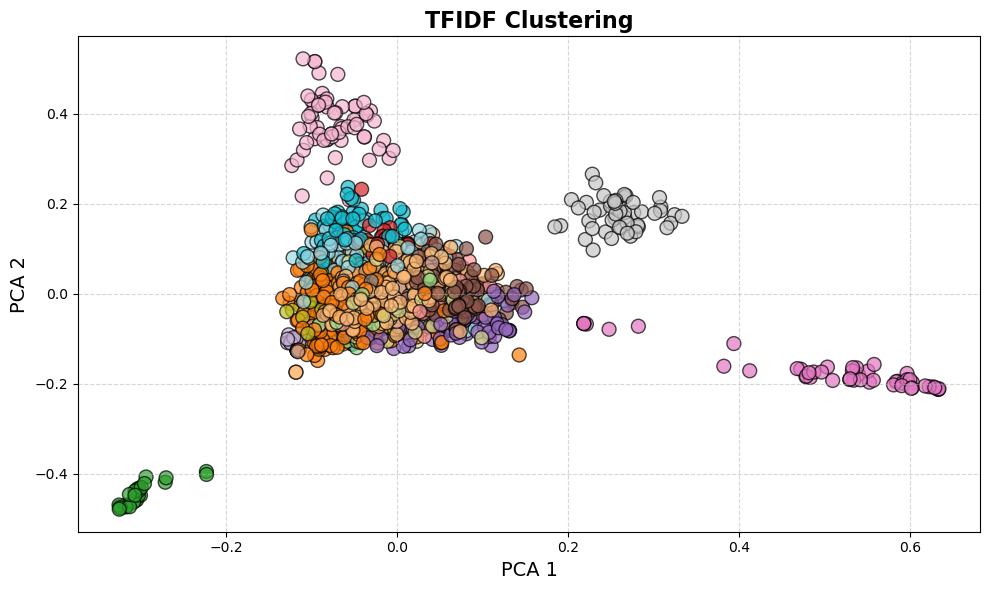

In [24]:
"""TF IDF CLUSTERING BASED ON JOB DESCRIPTIONS"""

q = input(
    "🧪 Do you want to perform TFIDF clustering (based on job descriptions)? (y/n) "
)

if q == "y":
    working_on("TFIDF Clustering (job descriptions)")
    tfidf_clusters, tfidf_matrix = TFIDF_cluster(
        data,
        save_clusters=save_clusters,
        n_clusters=20
    )
    visualize_cluster(
        tfidf_matrix,
        tfidf_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="tfidf_clusters.png",
        name="TFIDF Clustering"
    )
    tfidf_matrix = 0

🧪 Do you want to perform TFIDF clustering (based on industries and functions)? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: TFIDF Clustering (industries and functions)
:white_check_mark: [bold green]SUCCESS[/bold green]: David Bouldin score: 2.377


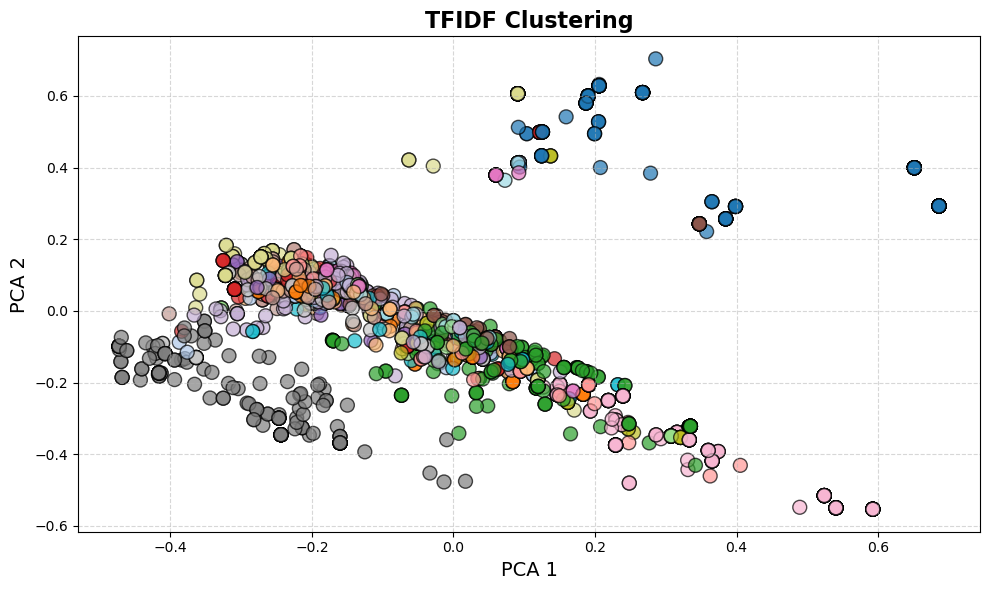

In [25]:
"""TF IDF CLUSTERING BASED ON INDUSTRIES AND FUNCTIONS"""

q = input(
    "🧪 Do you want to perform TFIDF clustering (based on industries and functions)? (y/n) "
)

if q == "y":
    working_on("TFIDF Clustering (industries and functions)")
    tfidf_clusters, tfidf_matrix = TFIDF_industries_and_functions_cluster(
        data,
        save_clusters=save_clusters,
        n_clusters=20
    )
    visualize_cluster(
        tfidf_matrix,
        tfidf_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="tfidf_industries_and_functions_clusters.png",
        name="TFIDF Clustering"
    )
    tfidf_matrix = 0


🧪 Do you want to perform TFIDF clustering (based on verbs from the job descriptions)? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: TFIDF Clustering (verbs)
:wrench: [bold green]WORKING ON[/bold green]: Extracting verbs from descriptions ...
:wrench: [bold green]WORKING ON[/bold green]: Clustering verbs ...
:white_check_mark: [bold green]SUCCESS[/bold green]: David Bouldin score: 5.752


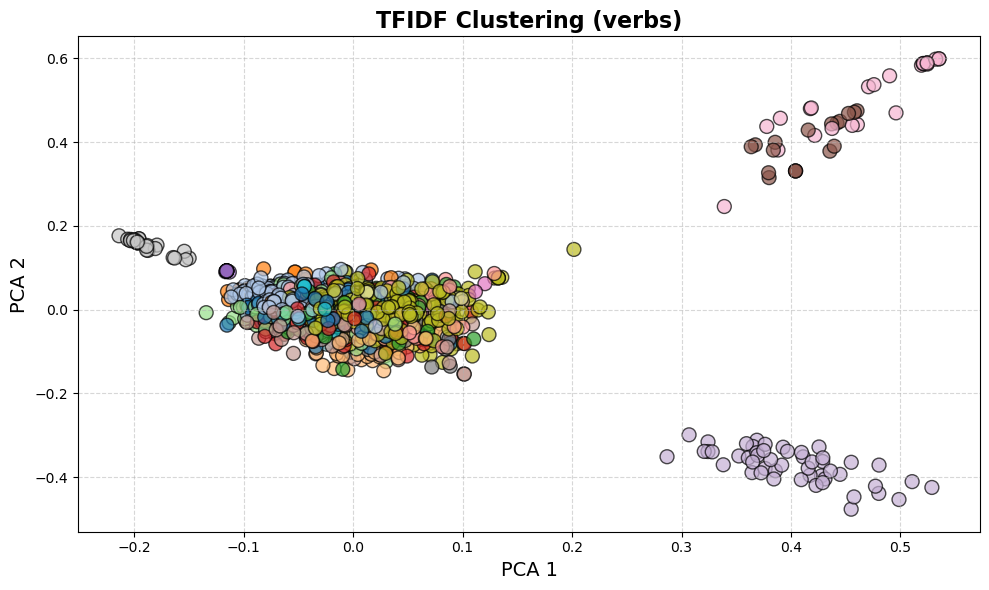

In [26]:
"""TF IDF CLUSTERING BASED ON VERBS FROM THE JOB DESCRIPTION"""

q = input(
    "🧪 Do you want to perform TFIDF clustering (based on verbs from the job descriptions)? (y/n) "
)

if q == "y":
    working_on("TFIDF Clustering (verbs)")
    data_string_desc = load_data(kind="processed")
    tfidf_clusters, tfidf_matrix = TFIDF_verbs_cluster(
        data_string_desc,
        save_clusters=save_clusters,
        n_clusters=20
    )
    visualize_cluster(
        tfidf_matrix,
        tfidf_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="tfidf_verbs_clusters.png",
        name="TFIDF Clustering (verbs)"
    )
    tfidf_matrix = 0


🧪 Do you want to perform TFIDF clustering (based on nouns from the job descriptions)? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: TFIDF Clustering (nouns)
:wrench: [bold green]WORKING ON[/bold green]: Extracting nouns from descriptions ...
:wrench: [bold green]WORKING ON[/bold green]: Clustering nouns ...
:white_check_mark: [bold green]SUCCESS[/bold green]: David Bouldin score: 4.884


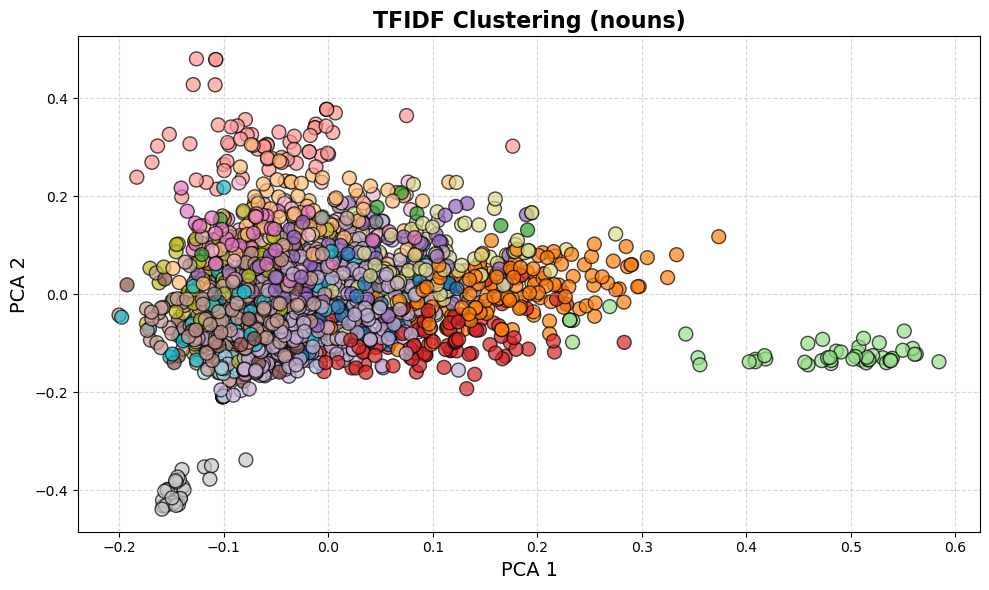

In [27]:
"""TF IDF CLUSTERING BASED ON NOUNS FROM THE JOB DESCRIPTION"""

q = input(
    "🧪 Do you want to perform TFIDF clustering (based on nouns from the job descriptions)? (y/n) "
)

if q == "y":
    working_on("TFIDF Clustering (nouns)")
    data = load_data(kind="processed")
    tfidf_clusters, tfidf_matrix = TFIDF_nouns_cluster(
        data,
        save_clusters=save_clusters,
        n_clusters=20
    )
    visualize_cluster(
        tfidf_matrix,
        tfidf_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="tfidf_nouns_clusters.png",
        name="TFIDF Clustering (nouns)"
    )
    tfidf_matrix = 0


🧪 Do you want to perform TFIDF clustering (based on adjectives from the job descriptions)? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: TFIDF Clustering (adjectives)
:wrench: [bold green]WORKING ON[/bold green]: Extracting adjectives from descriptions ...
:wrench: [bold green]WORKING ON[/bold green]: Clustering adjectives ...
:white_check_mark: [bold green]SUCCESS[/bold green]: David Bouldin score: 5.486


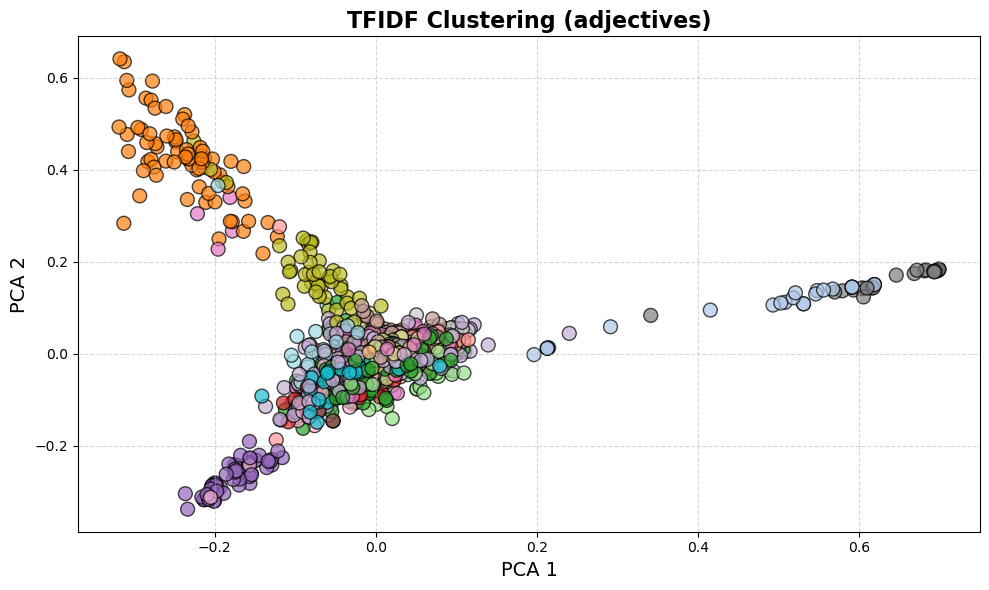

In [28]:
"""TF IDF CLUSTERING BASED ON ADJECTIVES FROM THE JOB DESCRIPTION"""

q = input(
    "🧪 Do you want to perform TFIDF clustering (based on adjectives from the job descriptions)? (y/n) "
)

if q == "y":
    working_on("TFIDF Clustering (adjectives)")
    data = load_data(kind="processed")
    tfidf_clusters, tfidf_matrix = TFIDF_adjectives_cluster(
        data,
        save_clusters=save_clusters,
        n_clusters=20
    )
    visualize_cluster(
        tfidf_matrix,
        tfidf_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="tfidf_adjectives_clusters.png",
        name="TFIDF Clustering (adjectives)"
    )
    tfidf_matrix = 0


🧪 Do you want to perform Word2Vec clustering? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: Word2Vec Clustering
:wrench: [bold green]WORKING ON[/bold green]: Creating vectors ...
:white_check_mark: [bold green]SUCCESS[/bold green]: David Bouldin score: 2.106


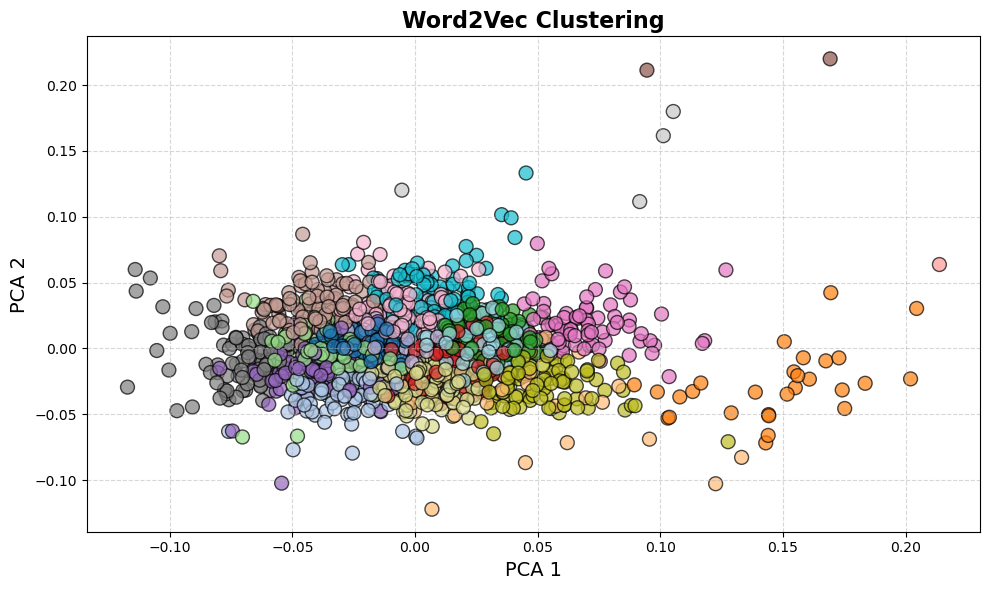

In [29]:
"""WORD2VEC CLUSTERING"""

q = input("🧪 Do you want to perform Word2Vec clustering? (y/n) ")

if q == "y":
    working_on("Word2Vec Clustering")
    word2vec_clusters, word2vec_vectors = word2vec_cluster(
        data,
        save_clusters=save_clusters,
        vector_size=100,
        window=5,
        min_count=1,
        workers=4,
        n_clusters=20
    )
    visualize_cluster(
        word2vec_vectors,
        word2vec_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="word2vec_clusters.png",
        name="Word2Vec Clustering"
    )


🧪 Do you want to perform one hot clustering (based on industries and functions)? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: One hot clustering (industries and functions)
:white_check_mark: [bold green]SUCCESS[/bold green]: David Bouldin score: 1.564


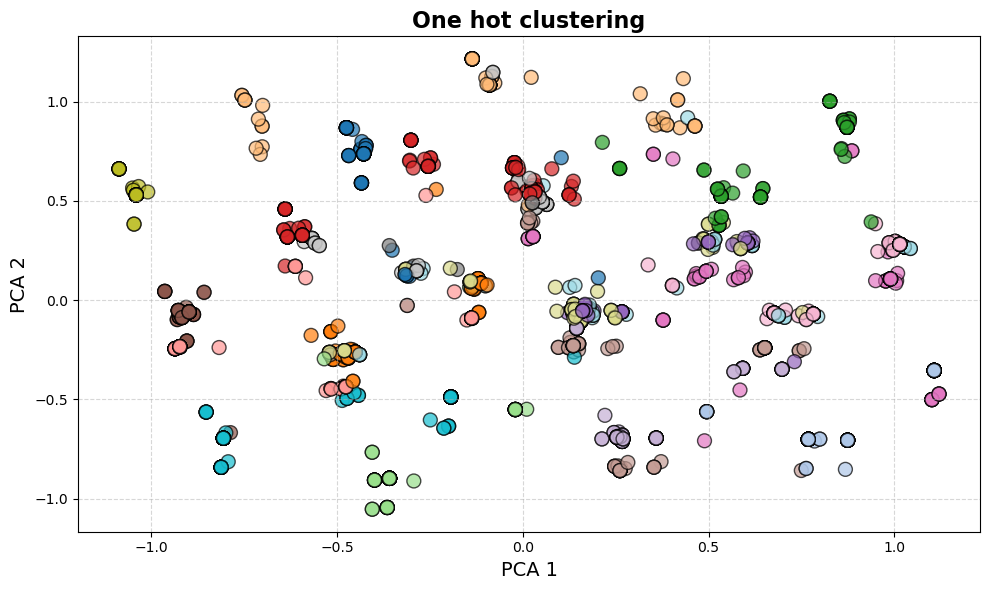

In [30]:
"""FEATURE CLUSTERING (ONE HOT ENCODED FUNCTIONS AND INDUSTRIES)"""
q = input(
    "🧪 Do you want to perform one hot clustering (based on industries and functions)? (y/n) "
)

if q == "y":
    working_on("One hot clustering (industries and functions)")
    onehot_clusters, onehot_features = onehot_cluster(
        data,
        save_clusters=save_clusters,
        n_clusters=20
    )
    visualize_cluster(
        onehot_features,
        onehot_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="onehot_clusters.png",
        name="One hot clustering"
    )

🧪 Do you want to perform Doc2Vec clustering? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: Doc2Vec Clustering
:wrench: [bold green]WORKING ON[/bold green]: Training doc2vec ...


Training doc2vec: 100%|#######################| 300/300 [06:00<00:00,  1.20s/it]


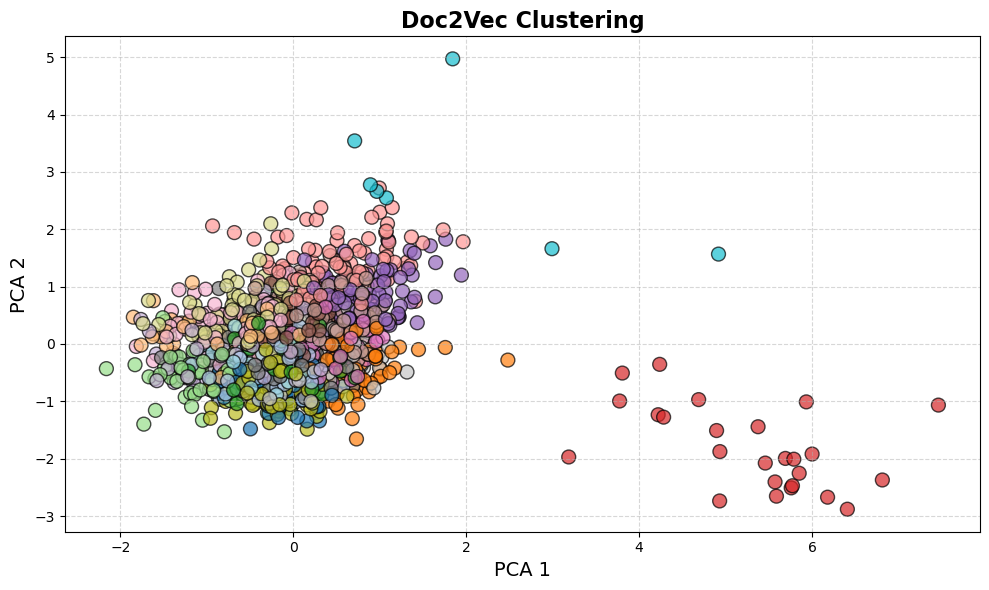

In [31]:
"""DOC2VEC CLUSTERING"""
q = input("🧪 Do you want to perform Doc2Vec clustering? (y/n) ")

if q == "y":
    working_on("Doc2Vec Clustering")
    doc2vec_clusters, doc2vec_vectors = doc2vec_cluster(
        data,
        save_clusters=save_clusters,
        method="kmeans",  # or "gmm"
        vector_size=100,
        alpha=0.025,
        min_alpha=0.00025,
        min_count=10,
        epochs=300,
        n_clusters=20
    )
    visualize_cluster(
        doc2vec_vectors,
        doc2vec_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="doc2vec_clusters.png",
        name="Doc2Vec Clustering"
    )

🧪 Do you want to perform similarity clustering (based on community discovery and kmeans)? (y/n) y
:wrench: [bold green]WORKING ON[/bold green]: Similarity Clustering
:wrench: [bold green]WORKING ON[/bold green]: Finding similarity ...


Calculating jaccard similarity: 100%|#######| 2325/2325 [03:16<00:00, 11.86it/s]


:wrench: [bold green]WORKING ON[/bold green]: Clustering based on community discovery ...
:wrench: [bold green]WORKING ON[/bold green]: Clustering based on kmean ...
:wrench: [bold green]WORKING ON[/bold green]: Saving clusters ...


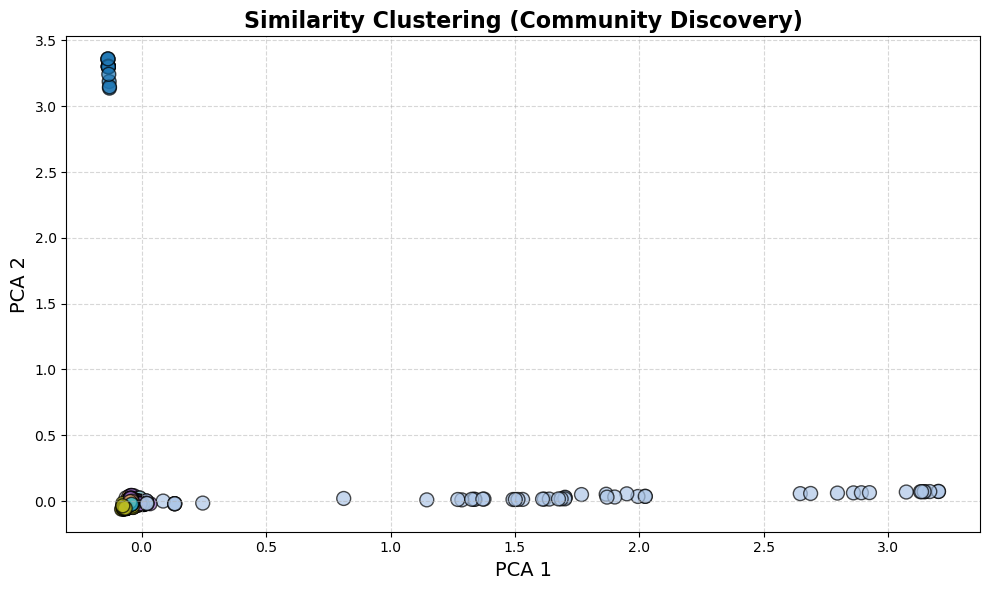

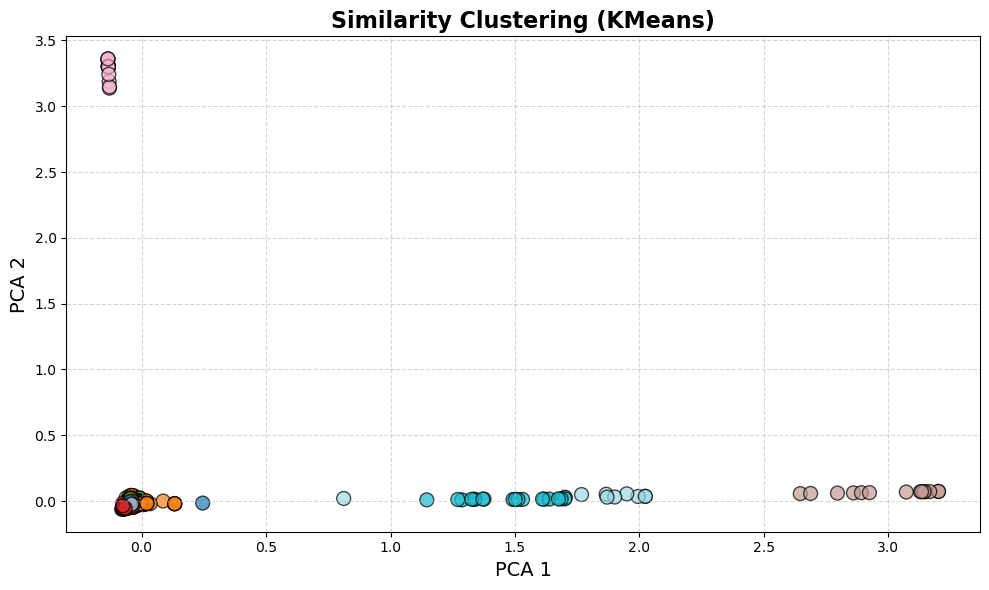

:white_check_mark: [bold green]SUCCESS[/bold green]: All clustering methods performed


In [32]:
"""SIMILARITY CLUSTERING"""
q = input("🧪 Do you want to perform similarity clustering (based on community discovery and kmeans)? (y/n) ")

if q == "y":
    working_on("Similarity Clustering")
    sim_community_discovery_clusters, sim_kmeans_clusters, sim_matrix = similarity_cluster(
        data,
        save_clusters=save_clusters,
        q=2,
        seeds=100,
        n_clusters=20
    )
    visualize_cluster(
        sim_matrix,
        sim_community_discovery_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="sim_community_discovery_clusters.png",
        name="Similarity Clustering (Community Discovery)"
    )

    visualize_cluster(
        sim_matrix,
        sim_kmeans_clusters["cluster"].to_numpy(),
        savefig=True,
        filename="sim_kmeans_clusters.png",
        name="Similarity Clustering (KMeans)"
    )

success("All clustering methods performed")

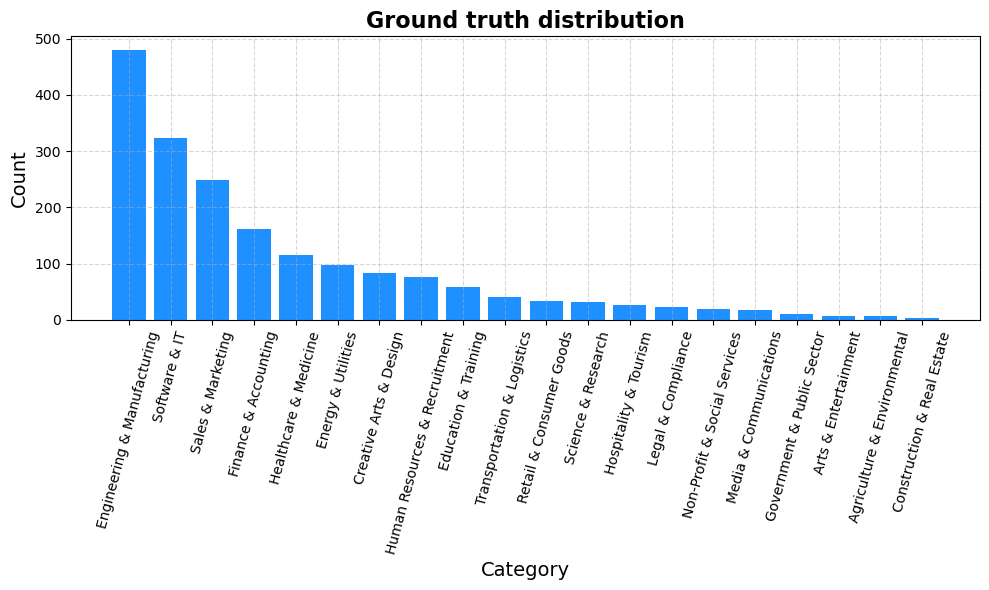

In [38]:
"""GROUND TRUTH INFERENCE"""
if not os.path.exists("../clusters/ground_truth_gpt.csv"):
    error("Ground truth not found: missing clusters/ground_truth_gpt.csv")
    print("First, you need to infer the ground truth. "
          "For this, we used GPT. You can reproduce the ground truth by first setting the environment variable "
          "OPEN_AI_KEY to your OpenAI key. Then you can run the following command in the terminal: "
          "python src/ground_truth_gpt.py")
    sys.exit()

gt = load_data(kind="ground_truth")
visualize_ground_truth(gt, savefig=True, filename="ground_truth.png")

In [37]:
"""EVALUATION OF CLUSTERS COMPARED TO GROUND TRUTH"""
evaluation()

:wrench: [bold green]WORKING ON[/bold green]: Comparing clusters ...
:white_check_mark: [bold green]SUCCESS[/bold green]: Normalized Mutual Information matrix:
ground_truth_gpt  word2vec tfidf_text tfidf_industries tfidf_nouns tfidf_adj tfidf_verbs industries_functions similarity_community_disc similarity_kmeans doc2vec_gmm doc2vec_kmeans
             1.0  0.078445   0.255119         0.266673     0.26444  0.209927    0.124144             0.244681                  0.106046          0.124662    0.040393       0.076889
        0.078445       1.0   0.154389         0.065124    0.143746  0.142736    0.137807             0.058048                  0.099084          0.105902    0.049277       0.188235
        0.255119  0.154389        1.0         0.232071    0.576915  0.404207     0.29929             0.199733                  0.278628          0.309614    0.059916       0.162781
        0.266673  0.065124   0.232071              1.0    0.218227  0.183395    0.153555             0.404653       

TypeError: reduction operation 'argmax' not allowed for this dtype

In [ ]:
"""SKILL EXTRACTION"""
q = input("🧠 Do you want to extract skills from the job descriptions "
          "(you need to set an env variable OPENAI_API_KEY)? (y/n) ")

if q == "y":
    working_on("Skill extraction")
    skill_extraction(save_skills=True)
    success("Skills saved to 'extracted_skills/skills_extracted_gpt3.csv")

In [ ]:
"""SKILL ANALYSIS"""
# TINGHUI's CODE